# Building a Weather Station with TensorFlow Lite for Microcontrollers
**Final Project for [Kodołamacz Data Science PRO](https://datasciencepro.kodolamacz.pl/?_gl=1*f9bzqb*_ga*NzExNzQ1MTc5LjE2NzQ5NzkxMTM.*_ga_L4TZ9764GC*MTY5NTc0MTM1NS44My4wLjE2OTU3NDEzNTUuNjAuMC4w) Bootcamp, Author: Michał Dąbrowski, PhD**

## Motivation

I have been inspired by [Smart weather station challenge](https://challenge.aiforgood.itu.int/match/matchitem/71). Here is a short description of the problem in that competition:

> Developing Countries is the area of the globe where land-based, in situ monitoring of weather and climate is at its scarcest, but at the same time has arguably the most potential to benefit society. Rainfall and temperature can have high spatial variability due to the strong feedback that can exist between the land and atmosphere. Temperature can change rapidly in space due to land-cover heterogeneity and changing altitude over complex mountainous terrain. This means that a weather station tens of kilometers away may measure conditions that have little relevance to your location, making it hard to make informed local decisions. Attempts can be made to supplement weather information with satellite data, but these infer rainfall and near surface temperature at spatially averaged scales exceeding 10km and are subject to considerable uncertainties despite advances in sensor technology; moreover some data such as near surface winds or solar flux are not available at all. Local weather information can have a huge impact on communities and applications enabled by granular weather data include agriculture, change in prices of commodities and early warning systems.

<p align="center" width="100%">
 <img src="./graphics/weather_map2.png" width="400"/>
</p>

The goal of this challenge was to develop a fully functioning low-power, reliable, accurate, easy to install and maintain cost effective [weather station based on a single device](./TinyML_Challenge_2022_CSEM_report.pdf) able to detect all weather parameters including __TPH__ (temperature, pressure and humidity), wind and rain with no moving parts based on ultra-low power machine learning at the edge, that can be deployed locally in a farm, for example, to provide local conditions and assist farmers in deciding when to plant crops. __Thus I decided to build my own microcontroller-based station to predict weather conditions in Warsaw using [TinyML framework](https://www.oreilly.com/library/view/tinyml/9781492052036/).__ In particular, to make a problem simpler I have decided to predict whether it will be snowing or not, depending on the weather conditions in the past hours.

### TinyML with TensorFlow Lite for Microcontrollers (TFLu) with Arduino Nano 33 BLE Sense
TinyML is a new technology that allows Machine Learning (ML) models to run on low-power microcontrollers that do not require a network infrastructure. Generally, these devices have limited memory (256kB SRAM for **Arduino Nano**) and computational capabilities (64 MHz), but they can _sense_ the physical environment through sensors and act based on the decisions taken by ML algorithms. It is firmly believed TinyML has a great role to play not only to reach the Sustainable Development Goals, but also to facilitate scientific research in areas such as environmental monitoring, physics of complex systems and energy management. One of the most popular and easy to develop model with is the [**Arduino Nano 33 BLE Sense**](https://docs.arduino.cc/hardware/nano-33-ble-sense) board with support from [**Tensor Flow Lite for Microcontrollers**](https://www.tensorflow.org/lite/microcontrollers) (TFLu) framework allowing running deep learning models on devices with a few kilobytes of memory, which we use to realize the current project. Written in C/C++, the library requires neither an operating system nor dynamic memory allocation. The **Arduino Nano 33 BLE Sens** currently has __TPH sensors__ which enable the temperature, humidity and atmospheric pressure measurements on-device in real time. Similar [weather stations](https://github.com/FlorinAndrei/WeatherStation) were realized in the past using different microcontrollers platforms and datasets e.g., [here](https://www.seeedstudio.com/blog/2021/02/23/build-a-tinyml-smart-weather-station-with-wio-terminal/) or [there](https://www.seeedstudio.com/blog/2021/02/23/build-a-tinyml-smart-weather-station-with-wio-terminal/) thus being helpful as as a source of inspiration and code snippets.

<p align="center" width="100%">
 <img src="https://courses.edx.org/assets/courseware/v1/c97238ff2db3e1872c67968473dc482f/asset-v1:HarvardX+TinyML3+1T2023+type@asset+block/pasted_image_0.png" width="600"/>
</p>

> __NOTE__: Excelent curated list of interesting resources on TinyML (articles, courses, books, and projects) is provided on [gitHub](https://github.com/gigwegbe/tinyml-papers-and-projects) profile.

## Project Dependencies

For details about the version of the Python packages installed when running the current notebook, see [requirements.txt](./requirements.txt).

In [1]:
# !pip install -r requirements.txt

Here is a **simplified tree of the project structure**, containig the most significant files and folders, described in details within this _Jupyter notebook_.
```
.
├── README.md
├── TinyML_project_MDabrowski.ipynb
├── arduino
│   ├── classification
│   ├── classification_ext
│   └── test_
├── notebook_ArduinoSketches.ipynb
├── notebook_Transformers.ipynb
├── outputs
│   ├── CALIBRATION.txt
│   ├── dataset.csv
│   ├── forecast
│   ├── forecast_model.tflite
│   └── model.h
├── requirements.txt
└── weather_warsaw.csv
```

### Python Libraries

In [2]:
import time, datetime
import pandas as pd
import numpy as np
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  # plot in `seaborn` style

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # ignore tf warnings

import warnings
warnings.filterwarnings('ignore')  # ignore sklearn warnings

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from keras.wrappers.scikit_learn import KerasClassifier
from wwo_hist import retrieve_hist_data  # WorldWeatherOnline API

### Constants

In [32]:
# above these values, we consider it as snow
MELTING_TEMPERATURE = 2
MIN_SNOW_CM = 0.5

NUM_EPOCHS = 50
BATCH_SIZE = 64

# repeatabilty of analysis results
np.random.seed(123)
tf.random.set_seed(123)

OUTPUT_DATASET_FILE = "dataset.csv"
TFL_MODEL_FILE = "forecast_model.tflite"
TFL_MODEL_HEADER_FILE = "model.h"
TF_MODEL = "forecast"

# WorldWeatherOnline API
PERSONAL_API_KEY = '<YOUR_PERSONAL_API_KEY>'
LOCATION = 'Syracuse'

## Importing weather data from _WorldWeatherOnline_

On the internet, there are various sources from which we can gather hourly weather data, but most of them are not free or have limited usage. I decided to use [**WorldWeatherOnline**](https://www.worldweatheronline.com/weather-api/) which has a free trial period for 30 days and provides simple [API](https://www.worldweatheronline.com/weather-api/api/docs/historical-weather-api.aspx) through HTTP requests to aquire the data (including historical data from July 1, 2008) for different locations worldwide. However, we can use an existing [Python wrapper](https://pypi.org/project/wwo-hist/) to export the data directly to __pandas__ `DataFrame` or save them into `CSV` file. Other solutions will require web scrapping (using `selenium` webdriver), gathering the data from [another database](https://www.weatherapi.com/) or external file.

> __NOTE:__ The original wrapper file needs to be modified as it does not work for `pandas` versions later than 1.3.5 (argument `closed` is no longer supported and needs to be removed from arguments list). Please find properly modified `retrieve_this_location()` function [here](./wwo_hist-0.0.7/wwo_hist/__init__.py) (`__init__.py` file) and replace the original `__init__.py` file from the Python packages directory corresponding to `wwo-hist` package.

In [33]:
# acquire data from 01-JUL-2008 to 31-AUG-2023 with an hourly frequency from desired location

try:
    df_weather = pd.read_csv(f'weather_{LOCATION.lower()}.csv')

except:
    # retrieve_hist_data returns a list of dataframe(s)
    df_weather = retrieve_hist_data(
                    PERSONAL_API_KEY,  # you need to register to obtain a personal API key (FREE 500 queries/day)
                    [LOCATION],
                    start_date='01-JUL-2008',
                    end_date='31-AUG-2023',
                    frequency=1,  # # weather conditions every 1 hour (costs 1 query for a whole month period per location)
                    location_label = False,
                    export_csv = False,
                    store_df = True)

    # export to CSV file
    df_weather[0].to_csv(f'weather_{LOCATION.lower()}.csv', index=False)

    df_weather = df_weather[0]  # in general, using API we can download weather forecast for a whole list of locations

finally:
    print(f"Data loaded from file: weather_{LOCATION.lower()}.csv")

Data loaded from file: weather_syracuse.csv


In [34]:
df_weather.head()

date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  2008-07-01 00:00:00        24        14           0.0     13.5        4   
1  2008-07-01 01:00:00        24        14           0.0     13.5        4   
2  2008-07-01 02:00:00        24        14           0.0     13.5        4   
3  2008-07-01 03:00:00        24        14           0.0     13.5        4   
4  2008-07-01 04:00:00        24        14           0.0     13.5        4   

   moon_illumination  moonrise   moonset   sunrise  ... WindGustKmph  \
0                  4  03:23 AM  07:56 PM  05:30 AM  ...           15   
1                  4  03:23 AM  07:56 PM  05:30 AM  ...           14   
2                  4  03:23 AM  07:56 PM  05:30 AM  ...           13   
3                  4  03:23 AM  07:56 PM  05:30 AM  ...           13   
4                  4  03:23 AM  07:56 PM  05:30 AM  ...           11   

   cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0         100        98       0.0      1010     16           0            286   
1         100        98       0.0      1010     16           0            295   
2         100        98       0.0      1010     16           0            304   
3         100        98       0.0      1011     16           0            313   
4          93        97       0.0      1011     15           1            311   

   windspeedKmph  location  
0              8  Syracuse  
1              8  Syracuse  
2              8  Syracuse  
3              8  Syracuse  
4              7  Syracuse  

[5 rows x 25 columns]

The `weather` dataset includes several weather conditions for each requested date and time. For example, we can ind the pressure in milibars, cloud coverage in percentage, visibility in kilometers, and of course other physical quantities. The effectiveness of ML algorithms depends heavily on the data used for training (hence _ML model is only as good as the dataset_). Considering the weather prediciton context, we know from physics that temperature and humidity affect snow formation. Thus, we gather historical hourly temperature, humidity and snowfall data to build a __TinyML__ snow forecasting application based on data from the past three hours.

> __NOTE__: Because in the future the microcontrollers will have more sensors or more memory to store additional data, in the **EDA** step of the analysis I decided to keep all the values corresponding to physically-measureable quantities. Most of them will be drop in the further steps.

In [35]:
df_weather.drop('location', axis=1, inplace=True)  # dropping 'location' column as the same for whole dataset
df_weather.shape

(153528, 24)

## Exploratory Data Analysis (EDA)

All the variables in the dataset are described briefly in [API documentation](https://www.worldweatheronline.com/weather-api/api/docs/historical-weather-api.aspx). The meaning for most of them is obvious but some of them need extra knowledge.

In [36]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153528 entries, 0 to 153527
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date_time          153528 non-null  object 
 1   maxtempC           153528 non-null  int64  
 2   mintempC           153528 non-null  int64  
 3   totalSnow_cm       153528 non-null  float64
 4   sunHour            153528 non-null  float64
 5   uvIndex            153528 non-null  int64  
 6   moon_illumination  153528 non-null  int64  
 7   moonrise           153528 non-null  object 
 8   moonset            153528 non-null  object 
 9   sunrise            153528 non-null  object 
 10  sunset             153528 non-null  object 
 11  DewPointC          153528 non-null  int64  
 12  FeelsLikeC         153528 non-null  int64  
 13  HeatIndexC         153528 non-null  int64  
 14  WindChillC         153528 non-null  int64  
 15  WindGustKmph       153528 non-null  int64  
 16  cl

In [39]:
df_weather.isna().sum()  # no missing values

date_time            0
maxtempC             0
mintempC             0
totalSnow_cm         0
sunHour              0
uvIndex              0
moon_illumination    0
moonrise             0
moonset              0
sunrise              0
sunset               0
DewPointC            0
FeelsLikeC           0
HeatIndexC           0
WindChillC           0
WindGustKmph         0
cloudcover           0
humidity             0
precipMM             0
pressure             0
tempC                0
visibility           0
winddirDegree        0
windspeedKmph        0
dtype: int64

In [40]:
df_weather.describe()  # only numerical variables

maxtempC       mintempC   totalSnow_cm        sunHour  \
count  153528.000000  153528.000000  153528.000000  153528.000000   
mean       13.217133       4.784118       0.090058       8.935345   
std        11.059113       9.815771       0.554070       3.570379   
min       -17.000000     -25.000000       0.000000       3.400000   
25%         4.000000      -2.000000       0.000000       5.700000   
50%        14.000000       5.000000       0.000000       9.000000   
75%        23.000000      13.000000       0.000000      11.600000   
max        34.000000      23.000000      10.900000      14.500000   

             uvIndex  moon_illumination      DewPointC     FeelsLikeC  \
count  153528.000000      153528.000000  153528.000000  153528.000000   
mean        3.177740          46.231827       5.324045       6.952080   
std         1.799599          31.285166       9.946288      13.103996   
min         1.000000           0.000000     -28.000000     -33.000000   
25%         1.000000          18.000000      -2.000000      -3.000000   
50%         3.000000          46.000000       6.000000       8.000000   
75%         5.000000          73.000000      14.000000      18.000000   
max         7.000000         100.000000      27.000000      41.000000   

          HeatIndexC     WindChillC   WindGustKmph     cloudcover  \
count  153528.000000  153528.000000  153528.000000  153528.000000   
mean        9.232342       6.730909      23.329653      52.953976   
std        11.091008      12.773904      11.202582      36.049099   
min       -25.000000     -33.000000       0.000000       0.000000   
25%         1.000000      -3.000000      15.000000      16.000000   
50%         9.000000       8.000000      22.000000      56.000000   
75%        18.000000      18.000000      30.000000      88.000000   
max        41.000000      34.000000      83.000000     100.000000   

            humidity       precipMM       pressure          tempC  \
count  153528.000000  153528.000000  153528.000000  153528.000000   
mean       81.154754       0.153048    1016.331451       8.940877   
std        13.786180       0.521590       7.810291      10.655227   
min        21.000000       0.000000     981.000000     -25.000000   
25%        73.000000       0.000000    1011.000000       1.000000   
50%        85.000000       0.000000    1016.000000       9.000000   
75%        92.000000       0.000000    1021.000000      18.000000   
max       100.000000      14.700000    1046.000000      34.000000   

          visibility  winddirDegree  windspeedKmph  
count  153528.000000  153528.000000  153528.000000  
mean        8.104724     218.814477      12.918588  
std         2.941642      79.560546       6.640205  
min         0.000000       0.000000       0.000000  
25%         7.000000     165.000000       8.000000  
50%        10.000000     228.000000      12.000000  
75%        10.000000     284.000000      17.000000  
max        10.000000     360.000000      44.000000

In [41]:
# unique values for each column

for column in df_weather:
    
    print(f'{column} - {len(df_weather[column].unique())}')
    print(df_weather[column].unique())
    print()

date_time - 132960
['2008-07-01 00:00:00' '2008-07-01 01:00:00' '2008-07-01 02:00:00' ...
 '2023-08-31 21:00:00' '2023-08-31 22:00:00' '2023-08-31 23:00:00']

maxtempC - 52
[ 24  28  21  25  30  31  32  26  23  27  29  22  19  20  18  17  16  12
  13  11  14  10   9   5   2   8   7  15   4  -1  -2  -4  -5   1   3  -3
  -9  -6 -10   0  -8 -11 -13 -12  -7   6  33 -14  34 -17 -16 -15]

mintempC - 49
[ 14  13  11  12  19  20  17  15  18  16  21   9  10   8   7   4   2   1
   3   0   5  -1  -2  -3  -5  -6  -7  -8  -4 -11 -15 -10 -12 -13 -14 -18
  -9 -16 -17   6 -19 -20 -22 -24  22  23 -21 -23 -25]

totalSnow_cm - 58
[ 0.   3.7  1.1  2.3  2.2  0.4  0.9  0.5  0.7  4.3  3.   4.5  1.8  1.4
  5.3  0.6  5.8  2.6  5.4  3.2  2.5  2.   1.3  1.   4.   7.3  1.2  0.8
  1.6  1.5  5.9  7.6  2.8  9.2  3.8  3.1  2.4  3.3  6.5  1.7  4.1  3.4
  4.8  8.2  2.1  9.   2.7  5.7  5.   3.9 10.9  1.9  6.   3.6  4.6  0.1
  0.2  0.3]

sunHour - 79
[13.5 14.5 12.5 10.5  9.4 12.4 11.4 10.3 13.4 11.3 14.2 11.6  9.3  8.2


[ 0  1  2  4  7  9 10  8  5  6  3]

winddirDegree - 361
[286 295 304 313 311 310 308 309 314 320 326 289 251 214 215 217 218 211
 204 197 193 188 183 202 213 216 219 212 195 186 198 209 221 208 196 184
 190 203 205 206 229 240 242 244 245 265 284 303 300 298 302 305 315 312
 307 288 270 277 328 336 343 350 347 340 334 322 331 341 248 146  43  56
  68  80 115 151 224 263 318 330 337 348 243 138  34  64  94 124 129 135
 141 136 133 145 156 168 169 143 130 122 107 126 165 171 177 189 194 237
 267 231 192 182 187 185 200 222 207 210 228 241 253 239 258 275 293 301
 296 283 273 262 268 278 282 291 285 281 269 246 150 163 159 149 139 178
 255 232  87  37  52  66  90 101 112 111 109 108 114 121 127 134 142 161
 174 173 170 162 176 180 172 191 199 201 234 233 226 230 274 290 287 276
 235 254 271 299 119  23  50  78 106 132 144 238 266 223 225 260 247  99
  16  85 154 179 306 292 323 324 325 327 329 338 345 353  21  77 148 128
 279 227 102  91 105 152 181 175 160 249 256 272 294 319 259 250 280

### Date-time index

Our data for weather forecast can be naturally represented as a time-series with observations collected every 1 hour. To check if we already have a time-series, we should search for missing or duplicated time indexes. But first of all, the should produce such indexes as _date-time_ data format.

In [42]:
df_weather = df_weather.set_index('date_time')
df_weather.index = pd.to_datetime(df_weather.index)
df_weather.head()

maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
date_time                                                                 
2008-07-01 00:00:00        24        14           0.0     13.5        4   
2008-07-01 01:00:00        24        14           0.0     13.5        4   
2008-07-01 02:00:00        24        14           0.0     13.5        4   
2008-07-01 03:00:00        24        14           0.0     13.5        4   
2008-07-01 04:00:00        24        14           0.0     13.5        4   

                     moon_illumination  moonrise   moonset   sunrise  \
date_time                                                              
2008-07-01 00:00:00                  4  03:23 AM  07:56 PM  05:30 AM   
2008-07-01 01:00:00                  4  03:23 AM  07:56 PM  05:30 AM   
2008-07-01 02:00:00                  4  03:23 AM  07:56 PM  05:30 AM   
2008-07-01 03:00:00                  4  03:23 AM  07:56 PM  05:30 AM   
2008-07-01 04:00:00                  4  03:23 AM  07:56 PM  05:30 AM   

                       sunset  ...  WindChillC  WindGustKmph  cloudcover  \
date_time                      ...                                         
2008-07-01 00:00:00  08:47 PM  ...          16            15         100   
2008-07-01 01:00:00  08:47 PM  ...          16            14         100   
2008-07-01 02:00:00  08:47 PM  ...          16            13         100   
2008-07-01 03:00:00  08:47 PM  ...          16            13         100   
2008-07-01 04:00:00  08:47 PM  ...          15            11          93   

                     humidity  precipMM  pressure  tempC  visibility  \
date_time                                                              
2008-07-01 00:00:00        98       0.0      1010     16           0   
2008-07-01 01:00:00        98       0.0      1010     16           0   
2008-07-01 02:00:00        98       0.0      1010     16           0   
2008-07-01 03:00:00        98       0.0      1011     16           0   
2008-07-01 04:00:00        97       0.0      1011     15           1   

                     winddirDegree  windspeedKmph  
date_time                                          
2008-07-01 00:00:00            286              8  
2008-07-01 01:00:00            295              8  
2008-07-01 02:00:00            304              8  
2008-07-01 03:00:00            313              8  
2008-07-01 04:00:00            311              7  

[5 rows x 23 columns]

#### Time-series check

In [43]:
# if sorted column is equal to the orginal column, it means the column is sorted properly
(df_weather.index == df_weather.index.sort_values()).all()

False

In [44]:
# difference between all rows is 1H (1D etc)
print(pd.infer_freq(df_weather.index))

None


Thus, our dataset does not represent the proper time-series yet and in the next step we need to provide necessary modifications.

### Missing indexes

In [45]:
# all the time steps from min to max date within our dataset with specified frequency

full_idx = pd.date_range(start=df_weather.index.min(), end=df_weather.index.max(), freq='1H')
len(full_idx), df_weather.shape[0], len(full_idx) - df_weather.shape[0]

(132960, 153528, -20568)

In [46]:
# missing indexes - those which present in 'full_idx' but absent in the dataset
missing_indexes = ~full_idx.isin(df_weather.index)  # 'True' if missing otherwise 'False'

print(f'Number of missing indexes: {np.sum(missing_indexes)}') 
print(f'Pecentage of entire dataset: {np.mean(missing_indexes)}')

Number of missing indexes: 0
Pecentage of entire dataset: 0.0


From the above we can conclude the only part prevent the dataset to represet a time-series are duplicates in the _time-index_ column we should drop.

### Duplicates

In [47]:
print(f'Number of duplicate indexes: {df_weather.index.duplicated().sum()}') 
print(f'Pecentage of entire dataset: {df_weather.index.duplicated().sum() / df_weather.shape[0]}')

Number of duplicate indexes: 20568
Pecentage of entire dataset: 0.1339690479912459


In [48]:
# condition to filter out duplicated values
not_duplicated = ~df_weather.index.duplicated()
df_weather = df_weather.loc[not_duplicated]

In [49]:
print(f'Number of duplicated indexes: {df_weather.index.duplicated().sum()}')

Number of duplicated indexes: 0


In [50]:
df_weather.shape

(132960, 23)

#### Time-series check

In [51]:
# if sorted column is equal to the orginal column, it means the column is sorted properly
(df_weather.index == df_weather.index.sort_values()).all()

True

In [52]:
# difference between all rows is 1H (1D etc)
print(pd.infer_freq(df_weather.index))

H


Finally, after excluding 13% of rows from the dataset, we end up with proper time-series to be analyzed. **I decided to drop the duplicated data for simplicity** but in another approach we will average the data values for the same duplicated index to check if it helps for machine learning model performace. Even after dropping the values, the remaining part of the dataset still has c.a. 150 000 rows, being quite a large dataset for trainig **TinyML model**.

### Non-numerical columns

In [53]:
non_numeric_columns = df_weather.select_dtypes(exclude=np.number).columns
non_numeric_columns

Index(['moonrise', 'moonset', 'sunrise', 'sunset'], dtype='object')

All the non-numerical columns contain _astronomical data_ which have nothing in common with weather forecasting so we drop them from further analysis.

In [54]:
df_weather.drop(non_numeric_columns, axis=1, inplace=True)
df_weather

maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
date_time                                                                 
2008-07-01 00:00:00        24        14           0.0     13.5        4   
2008-07-01 01:00:00        24        14           0.0     13.5        4   
2008-07-01 02:00:00        24        14           0.0     13.5        4   
2008-07-01 03:00:00        24        14           0.0     13.5        4   
2008-07-01 04:00:00        24        14           0.0     13.5        4   
...                       ...       ...           ...      ...      ...   
2023-08-31 19:00:00        22         9           0.0     11.6        5   
2023-08-31 20:00:00        22         9           0.0     11.6        5   
2023-08-31 21:00:00        22         9           0.0     11.6        5   
2023-08-31 22:00:00        22         9           0.0     11.6        5   
2023-08-31 23:00:00        22         9           0.0     11.6        5   

                     moon_illumination  DewPointC  FeelsLikeC  HeatIndexC  \
date_time                                                                   
2008-07-01 00:00:00                  4         16          16          16   
2008-07-01 01:00:00                  4         15          16          16   
2008-07-01 02:00:00                  4         15          16          16   
2008-07-01 03:00:00                  4         15          16          16   
2008-07-01 04:00:00                  4         15          15          15   
...                                ...        ...         ...         ...   
2023-08-31 19:00:00                100         11          16          16   
2023-08-31 20:00:00                100         11          16          16   
2023-08-31 21:00:00                100          8          13          13   
2023-08-31 22:00:00                100          8          13          12   
2023-08-31 23:00:00                100         11          14          13   

                     WindChillC  WindGustKmph  cloudcover  humidity  precipMM  \
date_time                                                                       
2008-07-01 00:00:00          16            15         100        98       0.0   
2008-07-01 01:00:00          16            14         100        98       0.0   
2008-07-01 02:00:00          16            13         100        98       0.0   
2008-07-01 03:00:00          16            13         100        98       0.0   
2008-07-01 04:00:00          15            11          93        97       0.0   
...                         ...           ...         ...       ...       ...   
2023-08-31 19:00:00          16            11           0        71       0.0   
2023-08-31 20:00:00          16             7           0        71       0.0   
2023-08-31 21:00:00          13             6           2        75       0.0   
2023-08-31 22:00:00          13             8           3        75       0.0   
2023-08-31 23:00:00          14            12           0        87       0.0   

                     pressure  tempC  visibility  winddirDegree  windspeedKmph  
date_time                                                                       
2008-07-01 00:00:00      1010     16           0            286              8  
2008-07-01 01:00:00      1010     16           0            295              8  
2008-07-01 02:00:00      1010     16           0            304              8  
2008-07-01 03:00:00      1011     16           0            313              8  
2008-07-01 04:00:00      1011     15           1            311              7  
...                       ...    ...         ...            ...            ...  
2023-08-31 19:00:00      1018     16          10            290              5  
2023-08-31 20:00:00      1019     16          10            261              3  
2023-08-31 21:00:00      1020     13          10            218              3  
2023-08-31 22:00:00      1020     12          10            189              4  
2023-08-31 23:00:

### Numerical columns

In [55]:
numeric_columns = df_weather.select_dtypes(include=np.number).columns
numeric_columns

Index(['maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour', 'uvIndex',
       'moon_illumination', 'DewPointC', 'FeelsLikeC', 'HeatIndexC',
       'WindChillC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'visibility', 'winddirDegree', 'windspeedKmph'],
      dtype='object')

Some columns have clear correspondence to physical quantities we can measure using microcontroller (or other physical) sensors but there are a lot of values which are very subjective (`FeelsLikeC`, `WindChillC`), have very vague meaning (`uvIndex`, `HeatIndexC`) or hard to measure accurately (`visibility`. Also, some colums like `maxTempC`, `minTempC` and `sunHour` (`moon_illumination` has astronomical meaning only) were measured once a day so cannot be used as a part of _real-time application_. **I decided to keep only the columns corresponding to proper physical quantities in our analysis.**

In [56]:
physical_columns = ['totalSnow_cm', 'DewPointC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
       'pressure', 'tempC', 'winddirDegree', 'windspeedKmph']

df_weather = df_weather[physical_columns]
df_weather

totalSnow_cm  DewPointC  WindGustKmph  cloudcover  \
date_time                                                                
2008-07-01 00:00:00           0.0         16            15         100   
2008-07-01 01:00:00           0.0         15            14         100   
2008-07-01 02:00:00           0.0         15            13         100   
2008-07-01 03:00:00           0.0         15            13         100   
2008-07-01 04:00:00           0.0         15            11          93   
...                           ...        ...           ...         ...   
2023-08-31 19:00:00           0.0         11            11           0   
2023-08-31 20:00:00           0.0         11             7           0   
2023-08-31 21:00:00           0.0          8             6           2   
2023-08-31 22:00:00           0.0          8             8           3   
2023-08-31 23:00:00           0.0         11            12           0   

                     humidity  precipMM  pressure  tempC  winddirDegree  \
date_time                                                                 
2008-07-01 00:00:00        98       0.0      1010     16            286   
2008-07-01 01:00:00        98       0.0      1010     16            295   
2008-07-01 02:00:00        98       0.0      1010     16            304   
2008-07-01 03:00:00        98       0.0      1011     16            313   
2008-07-01 04:00:00        97       0.0      1011     15            311   
...                       ...       ...       ...    ...            ...   
2023-08-31 19:00:00        71       0.0      1018     16            290   
2023-08-31 20:00:00        71       0.0      1019     16            261   
2023-08-31 21:00:00        75       0.0      1020     13            218   
2023-08-31 22:00:00        75       0.0      1020     12            189   
2023-08-31 23:00:00        87       0.0      1020     13            169   

                     windspeedKmph  
date_time                           
2008-07-01 00:00:00              8  
2008-07-01 01:00:00              8  
2008-07-01 02:00:00              8  
2008-07-01 03:00:00              8  
2008-07-01 04:00:00              7  
...                            ...  
2023-08-31 19:00:00              5  
2023-08-31 20:00:00              3  
2023-08-31 21:00:00              3  
2023-08-31 22:00:00              4  
2023-08-31 23:00:00              6  

[132960 rows x 10 columns]

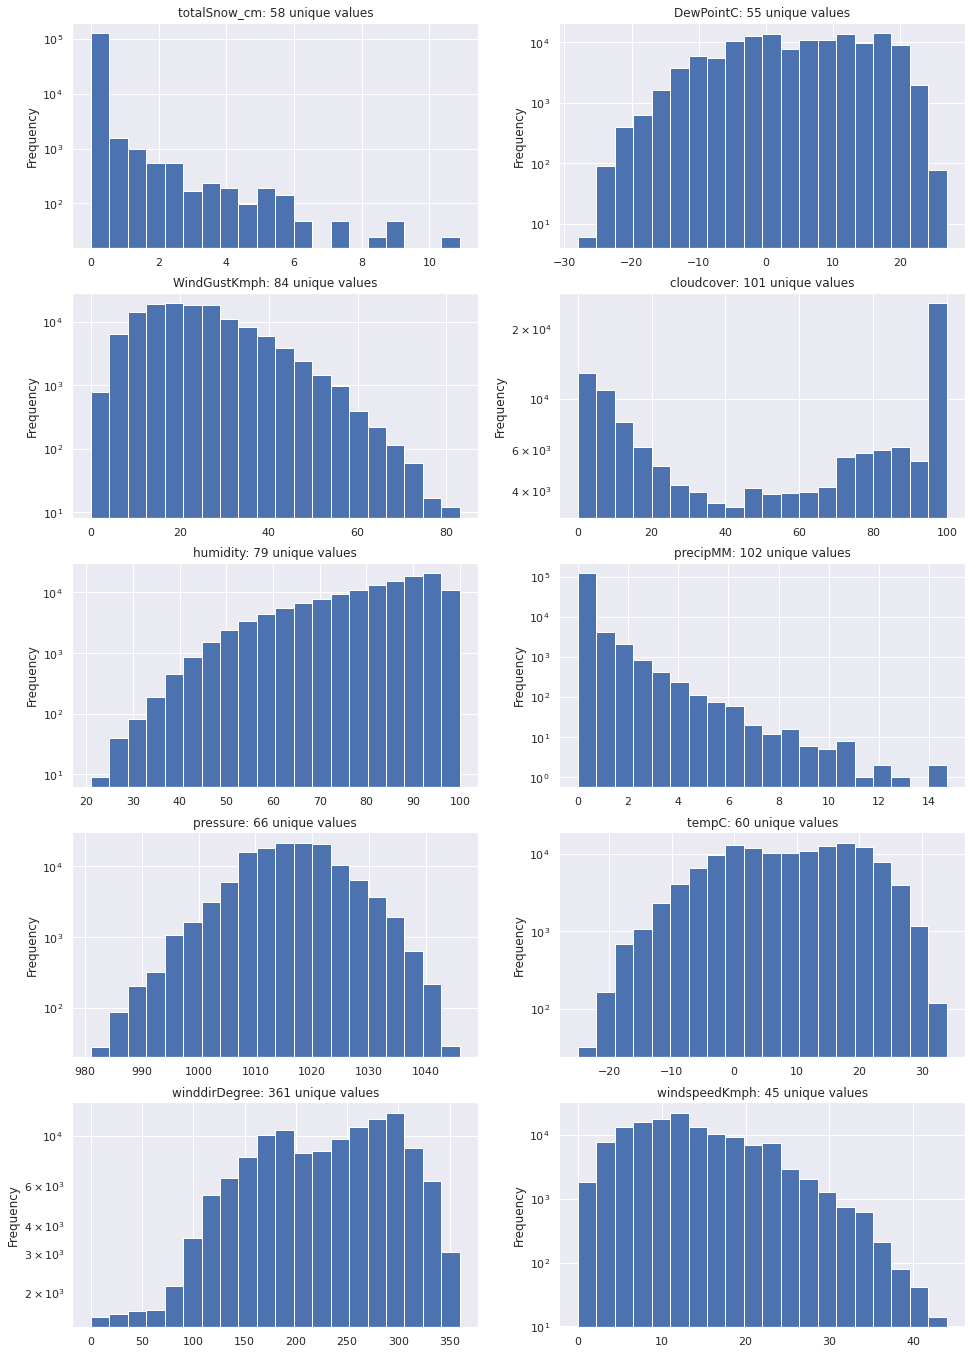

In [57]:
# logarithmic y-scale to see the tailing edges (because of lots of datapoint for 'zero' index category)

fig, axes = plt.subplots(5, 2, figsize=(16, 24))
axes = axes.flatten()

for idx, column in enumerate(physical_columns):
    df_weather[column].plot.hist(bins=20,
                                 title=f'{column}: {len(df_weather[column].unique())} unique values',
                                 logy=True,  # logy=False change plots to linear scale (to see Gaussian distributions)
                                 ax=axes[idx])
    
plt.show()

### Correlations

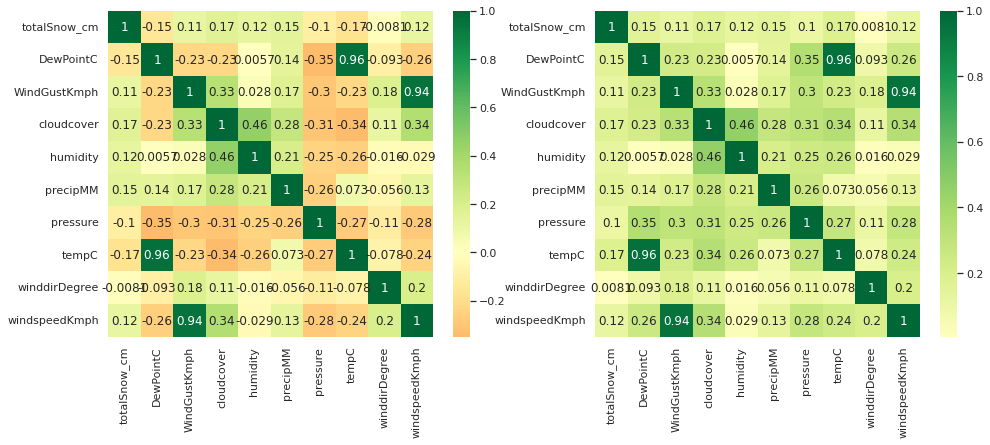

In [58]:
# plot Pearson's correlation (left) and its absolute value (right)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(df_weather.corr(), 
                 xticklabels=df_weather.corr().columns, 
                 yticklabels=df_weather.corr().columns, 
                 cmap='RdYlGn', 
                 center=0, 
                 annot=True,
                 ax=axes[0])

sns.heatmap(np.abs(df_weather.corr()), 
                 xticklabels=df_weather.corr().columns, 
                 yticklabels=df_weather.corr().columns, 
                 cmap='RdYlGn', 
                 center=0, 
                 annot=True,
                 ax=axes[1])

plt.show()

From the correlation maps above we see `DrewPointC` is strongly correlated with `tempC` which is obvious knowing the [definition of drew point](https://en.wikipedia.org/wiki/Dew_point). Also, `WindGustKmph` (short, strong wind) is strongly correlated with `windspeedKmph`. On the opposite, `winddirDegree` (wind direction) is very weakly correlated with any other variable thus we decided to drop these three values from further modeling (moreover, it will be hard to measure them using microcontroller).

In [59]:
df_weather.drop(['DewPointC', 'WindGustKmph', 'winddirDegree'], axis=1, inplace=True)
df_weather

totalSnow_cm  cloudcover  humidity  precipMM  pressure  \
date_time                                                                     
2008-07-01 00:00:00           0.0         100        98       0.0      1010   
2008-07-01 01:00:00           0.0         100        98       0.0      1010   
2008-07-01 02:00:00           0.0         100        98       0.0      1010   
2008-07-01 03:00:00           0.0         100        98       0.0      1011   
2008-07-01 04:00:00           0.0          93        97       0.0      1011   
...                           ...         ...       ...       ...       ...   
2023-08-31 19:00:00           0.0           0        71       0.0      1018   
2023-08-31 20:00:00           0.0           0        71       0.0      1019   
2023-08-31 21:00:00           0.0           2        75       0.0      1020   
2023-08-31 22:00:00           0.0           3        75       0.0      1020   
2023-08-31 23:00:00           0.0           0        87       0.0      1020   

                     tempC  windspeedKmph  
date_time                                  
2008-07-01 00:00:00     16              8  
2008-07-01 01:00:00     16              8  
2008-07-01 02:00:00     16              8  
2008-07-01 03:00:00     16              8  
2008-07-01 04:00:00     15              7  
...                    ...            ...  
2023-08-31 19:00:00     16              5  
2023-08-31 20:00:00     16              3  
2023-08-31 21:00:00     13              3  
2023-08-31 22:00:00     12              4  
2023-08-31 23:00:00     13              6  

[132960 rows x 7 columns]

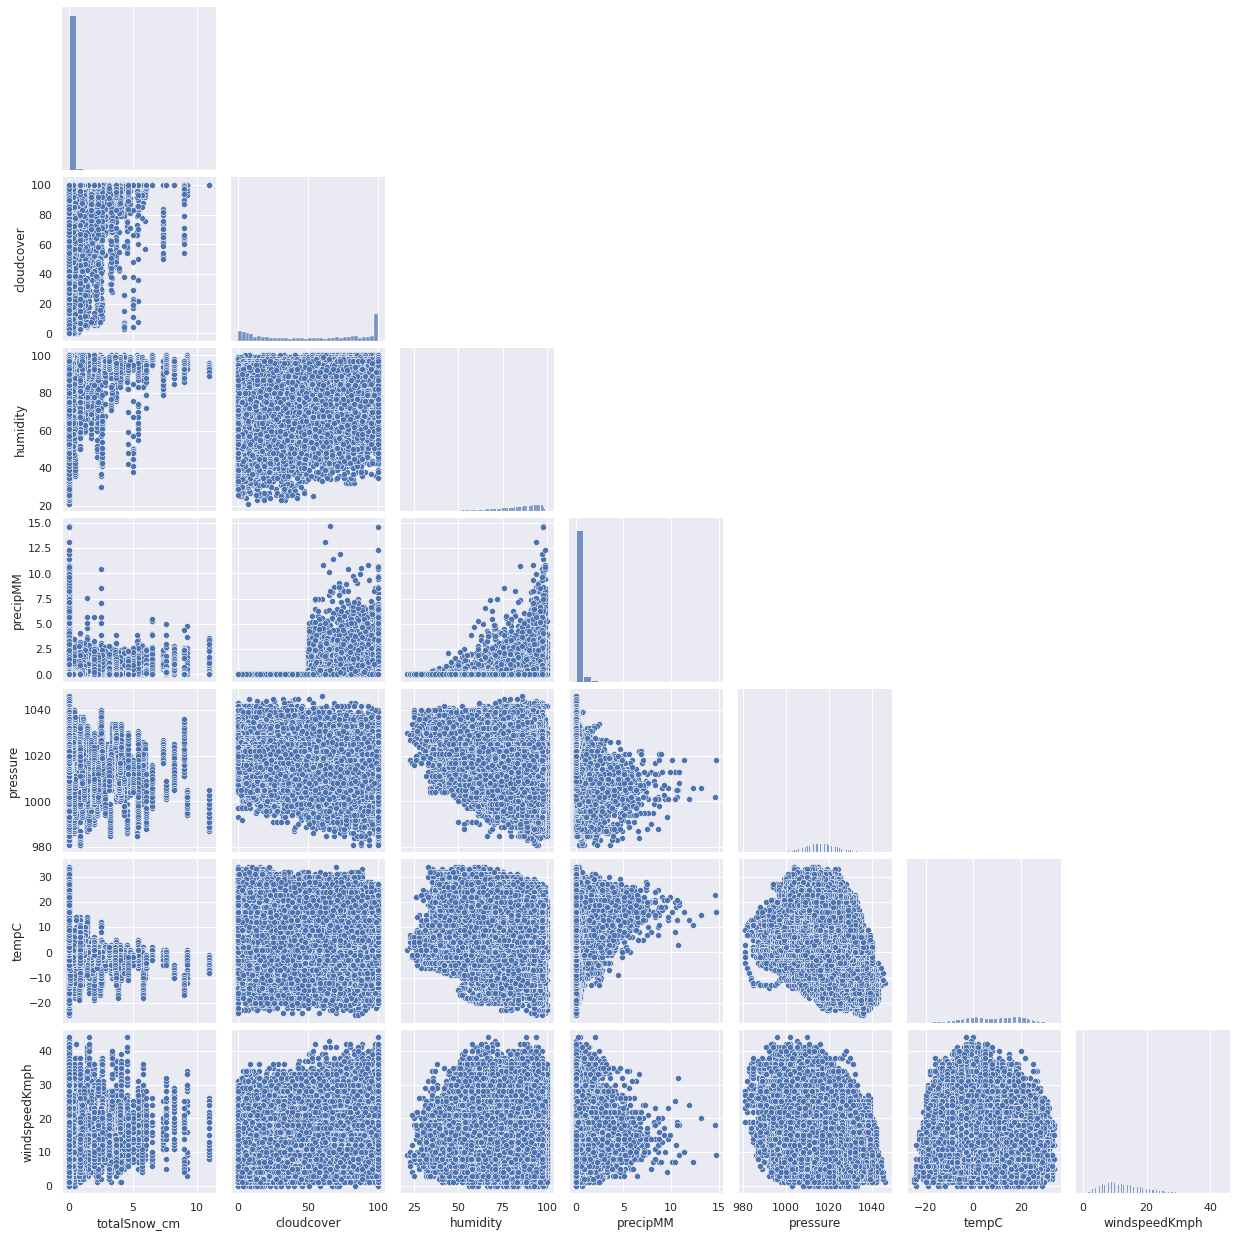

In [60]:
sns.pairplot(df_weather, kind='scatter', corner=True)
plt.show()

### Conclusions

More general approach will use **feature selector** to choose appropriate features based on the correlation with desired label (snow or no-snow). But as mentioned earlier, due to **restricted memory** of microcontroller and **available sensors**, the only physical quantities we are interested in are:
- `tempC`: the temperature in degrees Celsius
- `humidity`: the relative air humidity in percentage
- `totalSnow_cm`: total snowfall in centimeters

In [61]:
# extract temperature, humidity and snow precipitation
t_list = df_weather.tempC.astype(float).to_list()
h_list = df_weather.humidity.astype(float).to_list()
s_list = df_weather.totalSnow_cm.astype(float).to_list()

## Feature engineering

### Snow forecasting

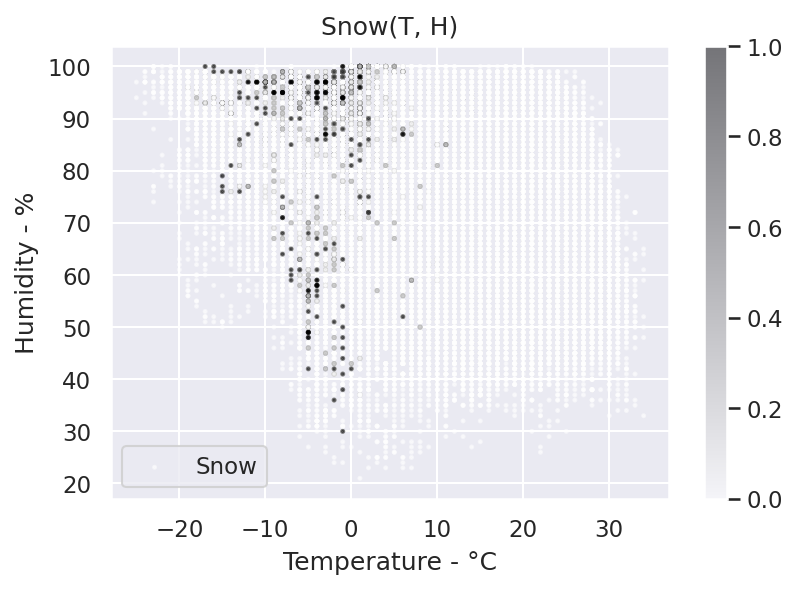

In [62]:
# explore the extracted physical quantities in a 2D scatter chart

def binarize(snow, threshold):
    if snow > threshold:
        return 1
    else:
        return 0

s_bin_list = [binarize(snow, MIN_SNOW_CM) for snow in s_list]

cm = plt.cm.get_cmap('gray_r')
plt.figure(figsize=(6, 4), dpi=150)
sc = plt.scatter(t_list, h_list, c=s_bin_list, cmap=cm, s=2, label="Snow", alpha=0.5)
plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("Temperature - °C")
plt.ylabel("Humidity - %")
plt.show()

As we can see from the distribution of the black dots, there are cases where the snow formation is reported for temperatures well above 0 Celsius degree. To simplify the analysis, we set the maximum temparature for snow formation as `MELTING_TEMP` and consider the snow formation only when the snowfall is above `MIN_SNOW_CM`. Since we are only forecasting snow, only two classes are needed (__classification problem__).

In [63]:
def gen_label(snow, temperature):
    '''Generate the output labels (Yes and No)'''
    if snow > MIN_SNOW_CM and temperature < MELTING_TEMPERATURE:
        return "Yes"
    else:
        return "No"

snow_labels = [gen_label(snow, temp) for snow, temp in zip(s_list, t_list)]

In [64]:
# build the dataset

csv_header = ["Temp0", "Temp1", "Temp2", "Humi0", "Humi1", "Humi2", "Snow"]

df_dataset = pd.DataFrame(list(zip(t_list[:-2], t_list[1:-1], t_list[2:],
                                   h_list[:-2], h_list[1:-1], h_list[2:], 
                                   snow_labels[2:])
                              ), columns = csv_header)

### Outliers

Because the data were measured automatically by physical electronics sensors, we should check if these sensors worked properly during data aquisition.

In [65]:
# Z-score criterium: |Z| > 3 for outlier

zscore_df = np.abs(df_dataset.select_dtypes([int, float]).apply(zscore))
zscore_df

Temp0     Temp1     Temp2     Humi0     Humi1     Humi2
0       0.662915  0.662919  0.662922  1.227976  1.227995  1.228007
1       0.662915  0.662919  0.662922  1.227976  1.227995  1.228007
2       0.662915  0.662919  0.568981  1.227976  1.227995  1.155629
3       0.662915  0.568978  0.662922  1.227976  1.155618  1.155629
4       0.568974  0.662919  0.756863  1.155600  1.155618  1.083252
...          ...       ...       ...       ...       ...       ...
132953  1.226561  0.944742  0.662922  1.739472  1.449959  0.726185
132954  0.944738  0.662919  0.662922  1.449964  0.726188  0.726185
132955  0.662915  0.662919  0.381098  0.726197  0.726188  0.436675
132956  0.662915  0.381095  0.287157  0.726197  0.436679  0.436675
132957  0.381092  0.287154  0.381098  0.436690  0.436679  0.431855

[132958 rows x 6 columns]

In [66]:
z= zscore_df.apply(lambda x: x < 3)
print(f'Pecentage of outliers in each column:\n{1 -np.mean(z)}')

Pecentage of outliers in each column:
0.002433099174175335


In [67]:
df_dataset = df_dataset[z.sum(axis=1) == len(z.columns)]  # only rows where outlier in none of the columns
df_dataset

Temp0  Temp1  Temp2  Humi0  Humi1  Humi2 Snow
0        16.0   16.0   16.0   98.0   98.0   98.0   No
1        16.0   16.0   16.0   98.0   98.0   98.0   No
2        16.0   16.0   15.0   98.0   98.0   97.0   No
3        16.0   15.0   16.0   98.0   97.0   97.0   No
4        15.0   16.0   17.0   97.0   97.0   96.0   No
...       ...    ...    ...    ...    ...    ...  ...
132953   22.0   19.0   16.0   57.0   61.0   71.0   No
132954   19.0   16.0   16.0   61.0   71.0   71.0   No
132955   16.0   16.0   13.0   71.0   71.0   75.0   No
132956   16.0   13.0   12.0   71.0   75.0   75.0   No
132957   13.0   12.0   13.0   75.0   75.0   87.0   No

[132008 rows x 7 columns]

### Imbalanced dataset

no-snow: 96.93% (127957), snow: 3.07% (4051)


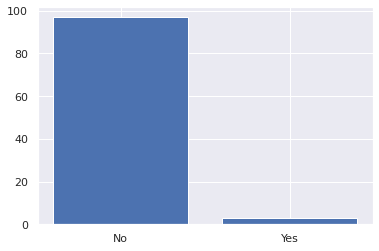

In [68]:
# balance the dataset by undersampling the majority class

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_old = round(len(df0.index) / len(df_dataset.index) * 100, 2)
num_snow_samples_old   = round(len(df1.index) / len(df_dataset.index) * 100, 2)

print(f'no-snow: {num_nosnow_samples_old}% ({len(df0.index)}), snow: {num_snow_samples_old}% ({len(df1.index)})')
plt.bar(np.unique(df_dataset['Snow'].values), [num_nosnow_samples_old, num_snow_samples_old]);

The original dataset is unbalanced because in the selected location (Warsaw, Poland), it typically snows just during the winter season. Since the minority class has many samples (around 1500), we can randomly undersample the majority class so the two categories have the same number of observations. **Another approach** might include oversampling the minority class (e.g.,  generating them using _SMOTE_ technique).

no-snow: 50.0% (4051), snow: 50.0% (4051)


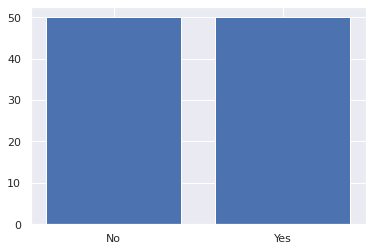

In [69]:
# Random subsampling of the majority class to guarantee 50% split
if len(df1.index) < len(df0.index):
    df0_sub = df0.sample(len(df1.index))
    df_dataset = pd.concat([df0_sub, df1])
else:
    df1_sub = df1.sample(len(df0.index))
    df_dataset = pd.concat([df1_sub, df0])

df0 = df_dataset[df_dataset['Snow'] == "No"]
df1 = df_dataset[df_dataset['Snow'] == "Yes"]

num_nosnow_samples_new = round((len(df0.index) / (len(df_dataset.index))) * 100, 2)
num_snow_samples_new = round((len(df1.index) / (len(df_dataset.index))) * 100, 2)

print(f'no-snow: {num_nosnow_samples_new}% ({len(df0.index)}), snow: {num_snow_samples_new}% ({len(df1.index)})')
plt.bar(np.unique(df_dataset['Snow'].values), [num_nosnow_samples_new, num_snow_samples_new]);

In [70]:
# Show number of samples
df_samples_results = pd.DataFrame.from_records(
                [["% No Snow", num_nosnow_samples_old, num_nosnow_samples_new],
                ["% Snow", num_snow_samples_old, num_snow_samples_new]],
            columns = ["Class", "Before - %", "After - %"], index="Class").round(2)

display(df_samples_results)

Before - %  After - %
Class                           
% No Snow       96.93       50.0
% Snow           3.07       50.0

### Standarization

In [71]:
# Get all values
t_list = df_dataset['Temp0'].tolist()
h_list = df_dataset['Humi0'].tolist()
t_list = t_list + df_dataset['Temp2'].tail(2).tolist()
h_list = h_list + df_dataset['Humi2'].tail(2).tolist()

# Calculate mean and standard deviation
t_avg = np.mean(t_list)
h_avg = np.mean(h_list)
t_std = np.std(t_list)
h_std = np.std(h_list)
print("COPY ME!")
print("Temperature - [MEAN, STD]  ", round(t_avg, 5), round(t_std, 5))
print("Humidity - [MEAN, STD]     ", round(h_avg, 5), round(h_std, 5))

COPY ME!
Temperature - [MEAN, STD]   3.25284 9.98975
Humidity - [MEAN, STD]      85.46607 12.25032


> __IMPORTANT:__ Copy the printed mean and standard deviation values printed as they will be required when deploying the __TinyML__ application.

Our input features exist in different numerical ranges. For example, humidity is always between 0 and 100, while the temperature on the Celsius scale can be negative and has a smaller positive numerical range than humidity. The following charts compare the raw and scaled input featue distributions. This is a typical scenario when dealing with various physical quantities and could impact the effectiveness of the model training. As you can observe, Z-score provides roughly the same value range (x-axis) for both temperature and humidity features.

In [72]:
# scale the input features with Z-score independently
def scaling(val, avg, std):
    '''Z-score scaling'''
    return (val - avg) / (std)

for col in ['Temp0', 'Temp1', 'Temp2']:
    df_dataset[col] = df_dataset[col].apply(lambda x: scaling(x, t_avg, t_std))

for col in ['Humi0', 'Humi1', 'Humi2']:
    df_dataset[col] = df_dataset[col].apply(lambda x: scaling(x, h_avg, h_std))

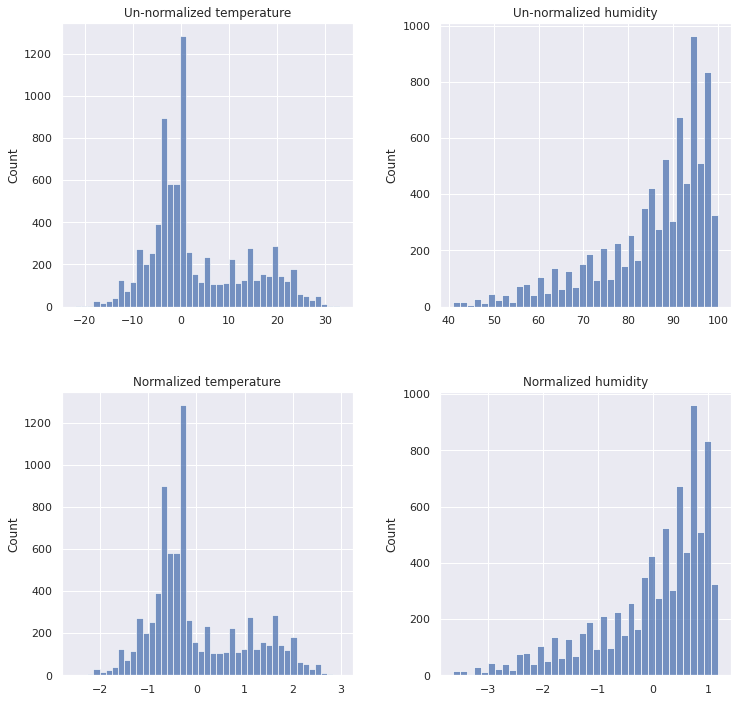

In [73]:
# visualize raw/scaled input features distributions

t_norm_list = df_dataset['Temp0'].tolist()
h_norm_list = df_dataset['Humi0'].tolist()
t_norm_list = t_norm_list + df_dataset['Temp2'].tail(2).tolist()
h_norm_list = h_norm_list + df_dataset['Humi2'].tail(2).tolist()

fig, ax=plt.subplots(2, 2, figsize=(12, 12))
plt.subplots_adjust(wspace = 0.3, hspace=0.3)

sns.histplot(t_list, ax=ax[0, 0])
ax[0, 0].set_title("Un-normalized temperature")
sns.histplot(h_list, ax=ax[0, 1])
ax[0, 1].set_title("Un-normalized humidity")

sns.histplot(t_norm_list, ax=ax[1, 0])
ax[1, 0].set_title("Normalized temperature")
sns.histplot(h_norm_list, ax=ax[1, 1])
ax[1, 1].set_title("Normalized humidity")

plt.show()

In [74]:
# export final dataset to CSV file
df_dataset.to_csv(f'./outputs/{OUTPUT_DATASET_FILE}', index=False)

## Transformers for EDA

After importing weather data either from `CSV` file or from web `API`, we can run all the above analysis more robustly using `sklearn` **transformers** defined in additional Jupyter notebook with [Transformers classes](./notebook_Transformers.ipynb). It is much more convenient for future experiments with different approaches to EDA process.

In [77]:
%run notebook_Transformers.ipynb

In [78]:
# import dataset to CSV file
raw_df = pd.read_csv(f'weather_{LOCATION.lower()}.csv')
raw_df.head()

date_time  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  \
0  2008-07-01 00:00:00        24        14           0.0     13.5        4   
1  2008-07-01 01:00:00        24        14           0.0     13.5        4   
2  2008-07-01 02:00:00        24        14           0.0     13.5        4   
3  2008-07-01 03:00:00        24        14           0.0     13.5        4   
4  2008-07-01 04:00:00        24        14           0.0     13.5        4   

   moon_illumination  moonrise   moonset   sunrise  ... WindGustKmph  \
0                  4  03:23 AM  07:56 PM  05:30 AM  ...           15   
1                  4  03:23 AM  07:56 PM  05:30 AM  ...           14   
2                  4  03:23 AM  07:56 PM  05:30 AM  ...           13   
3                  4  03:23 AM  07:56 PM  05:30 AM  ...           13   
4                  4  03:23 AM  07:56 PM  05:30 AM  ...           11   

   cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  \
0         100        98       0.0      1010     16           0            286   
1         100        98       0.0      1010     16           0            295   
2         100        98       0.0      1010     16           0            304   
3         100        98       0.0      1011     16           0            313   
4          93        97       0.0      1011     15           1            311   

   windspeedKmph  location  
0              8  Syracuse  
1              8  Syracuse  
2              8  Syracuse  
3              8  Syracuse  
4              7  Syracuse  

[5 rows x 25 columns]

In [79]:
steps = [
    ('location_remover', RemoveColumnsTransformer(columns_to_remove='location')),
    ('NA_imputer', ImputeColsTransformer()),
    ('timeseries_transformer', MakeTSTransformer(index_column='date_time')),
    ('cutdates_transformer', CutDateTransformer(start_date='2008-07-01', end_date='2023-08-31')),
    ('numeric_selector', SelectColumnsByTypeTransformer(columns_type='number')),
    ('hourly_resampler', HourlyResampleTransformer()),
    ('duplicates_remover', RemoveDuplicatesTransformer()),
    ('cols_selector', SelectColumnsTransformer(
        columns_to_select=['totalSnow_cm', 'DewPointC', 'WindGustKmph', 'cloudcover', 'humidity', 'precipMM',
                           'pressure', 'tempC', 'winddirDegree', 'windspeedKmph'])
    ),
    ('cols_remover', RemoveColumnsTransformer(columns_to_remove=['DewPointC', 'WindGustKmph', 'winddirDegree'])),
    ('features_transformer', FeatureEngineeringTransformer(min_snow=MIN_SNOW_CM,
                                                           melting_temp=MELTING_TEMPERATURE)),
    ('outliers_remover', RemoveOutliersTransformer()),
    ('data_balancer', BalanceDatasetTransformer(label_column='Snow')),
    ('standarizer', StandarizeColumnsTransformer())
]

pipeline = Pipeline(steps=steps)
pipeline.fit(raw_df)

Pipeline(steps=[('location_remover',
                 RemoveColumnsTransformer(columns_to_remove='location')),
                ('NA_imputer', ImputeColsTransformer()),
                ('timeseries_transformer', MakeTSTransformer()),
                ('cutdates_transformer',
                 CutDateTransformer(end_date='2023-08-31',
                                    start_date='2008-07-01')),
                ('numeric_selector', SelectColumnsByTypeTransformer()),
                ('hourly_resampler', HourlyR...
                                                             'pressure',
                                                             'tempC',
                                                             'winddirDegree',
                                                             'windspeedKmph'])),
                ('cols_remover',
                 RemoveColumnsTransformer(columns_to_remove=['DewPointC',
                                                             'WindGustKmph',
                                                             'winddirDegree'])),
                ('features_transformer', FeatureEngineeringTransformer()),
                ('outliers_remover', RemoveOutliersTransformer()),
                ('data_balancer', BalanceDatasetTransformer()),
                ('standarizer', StandarizeColumnsTransformer())])

In [80]:
df_final = pipeline.transform(raw_df)
df_final

Temp0     Temp1     Temp2     Humi0     Humi1     Humi2 Snow
0     0.081704  0.081704 -0.018786  0.999957  0.920036  0.840115   No
1     0.584154  0.584154  0.584154 -1.397667 -1.157905 -0.998063   No
2    -1.325156 -1.325156 -1.325156 -0.118934  0.040907  0.200749   No
3     0.684644  0.584154  0.584154  0.200749  0.280670  0.360590   No
4     0.081704  0.182194  0.081704 -0.438618 -0.039014  0.040907   No
...        ...       ...       ...       ...       ...       ...  ...
8097 -0.722216 -0.621726 -0.320256  0.040907  0.040907 -0.358697  Yes
8098 -0.621726 -0.320256 -0.219766  0.040907 -0.358697 -0.838222  Yes
8099  0.081704  0.282684 -0.219766 -0.358697 -2.356717  0.760194  Yes
8100  0.282684 -0.219766 -0.420746 -2.356717  0.760194  0.200749  Yes
8101 -0.219766 -0.420746 -0.521236  0.760194  0.200749  0.120828  Yes

[8102 rows x 7 columns]

In [81]:
# export final dataset to CSV file
df_final.to_csv(f'./outputs/{OUTPUT_DATASET_FILE}', index=False)

As a final step in data preparation for future deployment of deep learning model into microcontroller, we save _mean value_ and _standard deviation_ of both _temperature_ and _humidity_ into text file `outputs/CALIBRATION.txt` from where they should be copy into `C` code of **TinyML** application.

In [82]:
# save TEMPERATURE_MEAN, TEMPERATURE_STD, HUMIDITY_MEAN, and HUMIDITY_STD into text file for calibration

print(f'TEMPERATURE_MEAN = {round(pipeline.named_steps["standarizer"].t_avg, 5)}')
print(f'TEMPERATURE_STD  = {round(pipeline.named_steps["standarizer"].t_std, 5)}')
print(f'HUMIDITY_MEAN    = {round(pipeline.named_steps["standarizer"].h_avg, 5)}')
print(f'HUMIDITY_STD     = {round(pipeline.named_steps["standarizer"].h_std, 5)}')

with open('./outputs/CALIBRATION.txt', 'w') as f:
    
    f.write(f'TEMPERATURE_MEAN = {round(pipeline.named_steps["standarizer"].t_avg, 5)}\n')
    f.write(f'TEMPERATURE_STD  = {round(pipeline.named_steps["standarizer"].t_std, 5)}\n')
    f.write(f'HUMIDITY_MEAN    = {round(pipeline.named_steps["standarizer"].h_avg, 5)}\n')
    f.write(f'HUMIDITY_STD     = {round(pipeline.named_steps["standarizer"].h_std, 5)}\n')

TEMPERATURE_MEAN = 3.18694
TEMPERATURE_STD  = 9.95124
HUMIDITY_MEAN    = 85.48815
HUMIDITY_STD     = 12.51239


## Simple Deep Learning (DL) Model

When working with TinyML framework, we are limited __(?!)__ to the [operators](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/micro_mutable_op_resolver.h) offered by **TFLu** library which means we are restricted to different types of neural networks excluding other machine learning models (logistic regression, SVC, decission trees, random forests, etc.) offered by `sklearn`. First, the model is trained on PC (or in the cloud), then converted to __TFLu__ format and deployed on microcontroller as a part of `C/C++` application

### Dataset preparation

In [83]:
# extract the input features and output labels from the df_dataset Pandas DataFrame

df_dataset = pd.read_csv(f'./outputs/{OUTPUT_DATASET_FILE}')

X = df_dataset.drop('Snow', axis=1)
y = df_dataset['Snow']

In [84]:
# encode the labels to numerical values

labelencoder = LabelEncoder()
y_encoded = labelencoder.fit_transform(y)

From the original dataset, we assign 80% records to the training set, 10% to the validation set, and last 10% to the test dataset. With this split, the validation and test datasets contain roughly 250 samples each, enough to see if the model works properly.

In [85]:
# split the dataset into train (80%), validation (10%), and test (10%) datasets

# Split 1 (80% vs 20%)
X_train, X_validate_test, y_train, y_validate_test = train_test_split(X, y_encoded, test_size=0.2, random_state=7)
# Split 2 (50% vs 50%)
X_test, X_validate, y_test, y_validate = train_test_split(X_validate_test, y_validate_test, test_size=0.5, random_state=13)

### Model training

One of the most critical aspects to consider when deploying DL networks for __TinyML__ is the model size, generally defined as the memory required for storing the weights (as microcontrollers have very limited physical memory). The created DL model is a __binary classifier__ with an input layer providing the six input features to the network (the temperature and humidity for each of the last three hours) and one output node returning the probability of snowing weather. The structure of the model (consisting all hidden layers) is illustrated in the diagram:

<br>
<p align="center" width="100%">
 <img src="./graphics/NN_scheme1.png" width="600"/>
</p>

<br>

In [104]:
# create the model with Keras API

model = Sequential()

model.add(Dense(12, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 12)                84        
                                                                 
 dropout_3 (Dropout)         (None, 12)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 13        
                                                                 
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________


> __NOTE:__ In __TinyML__ it is important to keep an eye on the number of weights because it strongly affects microcontroller memory utilization.

In [105]:
# train the model
history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_validate, y_validate))

Epoch 1/50
102/102 [==============================] - 2s 8ms/step - loss: 0.5226 - accuracy: 0.7710 - val_loss: 0.4572 - val_accuracy: 0.8089
Epoch 2/50
102/102 [==============================] - 1s 6ms/step - loss: 0.4391 - accuracy: 0.8135 - val_loss: 0.3983 - val_accuracy: 0.8163
Epoch 3/50
102/102 [==============================] - 1s 8ms/step - loss: 0.4013 - accuracy: 0.8312 - val_loss: 0.3718 - val_accuracy: 0.8422
Epoch 4/50
102/102 [==============================] - 1s 7ms/step - loss: 0.3845 - accuracy: 0.8389 - val_loss: 0.3551 - val_accuracy: 0.8582
Epoch 5/50
102/102 [==============================] - 1s 8ms/step - loss: 0.3699 - accuracy: 0.8448 - val_loss: 0.3424 - val_accuracy: 0.8644
Epoch 6/50
102/102 [==============================] - 1s 8ms/step - loss: 0.3612 - accuracy: 0.8486 - val_loss: 0.3342 - val_accuracy: 0.8668
Epoch 7/50
102/102 [==============================] - 1s 8ms/step - loss: 0.3529 - accuracy: 0.8494 - val_loss: 0.3281 - val_accuracy: 0.8631
Epoch 

In [106]:
# loss and accuracy metrics on test dataset
model.evaluate(X_test, y_test, verbose=0)

[0.27819570899009705, 0.8703703880310059]

In [89]:
# save the entire TensorFlow model as a SavedModel (ProtoBuffer, TF checkpoint and training parameters)
model.save(f'outputs/{TF_MODEL}')

INFO:tensorflow:Assets written to: outputs/forecast/assets


INFO:tensorflow:Assets written to: outputs/forecast/assets


Exporting the trained network as `SavedModel` saves the training graph (network architecture, weights, hiperparameters and checkpoints) thus such **TensorFlow** model is perfect for sharing or resuming a training session but not suitable for microcontroller deployment due to computational and memory constraints. Later on we will transform **TensorFlow** model into [**TensorFlow Lite (TFLite)**](https://www.tensorflow.org/lite/guide) model, and finally convert it to C-byte array.

## Evaluation and Performance

203/203 [==============================] - 1s 3ms/step


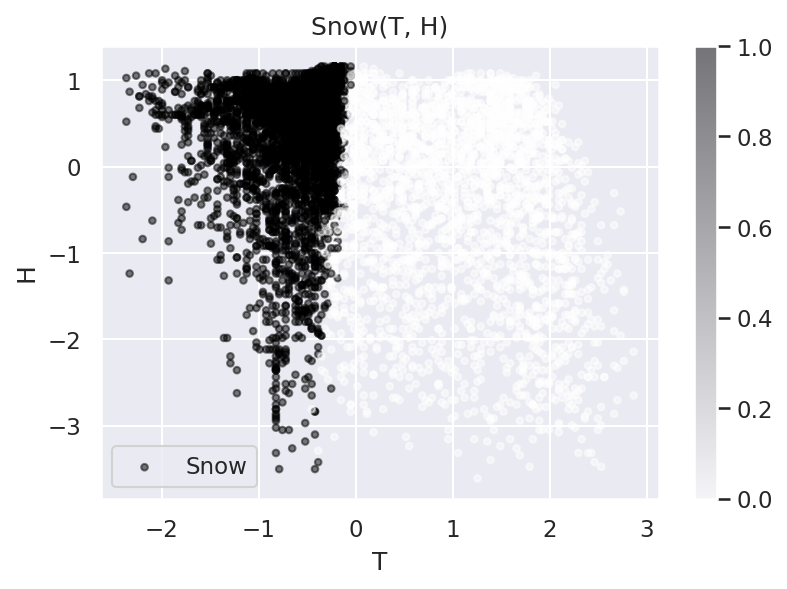

In [107]:
temp = np.mean(X_train[['Temp0', 'Temp1', 'Temp2']], axis=1).values
humi = np.mean(X_train[['Humi0', 'Humi1', 'Humi2']], axis=1).values

preds = (model.predict(X_train) > 0.5).astype("int32")

cm = plt.cm.get_cmap('gray_r')
plt.figure(figsize=(6, 4), dpi=150)
sc = plt.scatter(temp, humi, s=10, c=preds, cmap=cm, label="Snow", alpha=0.5)

plt.colorbar(sc)
plt.legend()
plt.grid(True)
plt.title("Snow(T, H)")
plt.xlabel("T")
plt.ylabel("H")
plt.show()

After the process of model training we see, that boundary was found between states with snowing and non-snowing weather. Interestingly, for lower temperatures the lower humidity is required for snowing conditions which was not obvious before analysis, assuming no expert-domain knowledge. Note the cluster for snowing weather is very dense compared to the other due to undersampling of the points with non-snowing labels in the dataset.

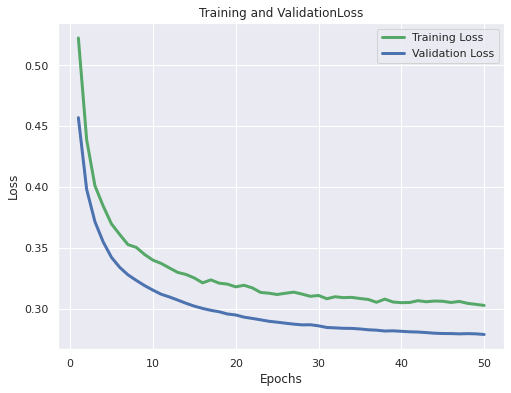

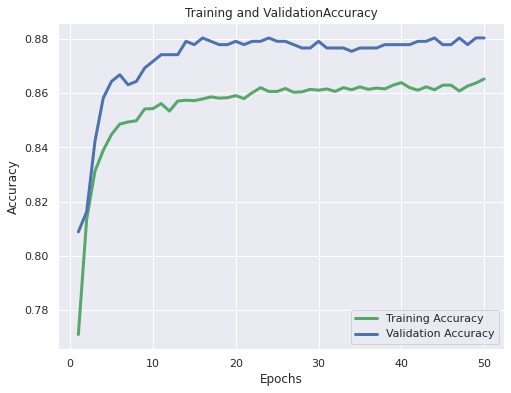

In [108]:
# analyze the accuracy and loss after each training epoch

loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, len(loss_train) + 1)  # range(1, N_EPOCHS + 1) does not include early stopping condition

def plot_train_val_history(X, y_train, y_val, type_txt):
    plt.figure(figsize = (8, 6))
    plt.plot(X, y_train, 'g', linewidth=3, label='Training ' + type_txt)
    plt.plot(X, y_val, 'b', linewidth=3, label='Validation ' + type_txt)
    plt.title('Training and Validation' + type_txt)
    plt.xlabel('Epochs')
    plt.ylabel(type_txt)
    plt.legend()
    plt.show()

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

From the plots we see the accuracy and loss of our model in each training epoch thus can see the trend of model performance. The validation accuracy and loss obtain _a plateau_ after c.a. 10 epochs and there is no evidence of overfitting or underfitting (exceptional smaller loss for validation rather than training set can be explained by the fact the validation loss is calculated at the end of each training epoch). Thus, we should consider terminating the training earlier to prevent overfitting for other datasets (using e.g., `EarlyStopping()` method). However, accuracy and loss are not enough to judge the model performance.

26/26 [==============================] - 0s 2ms/step


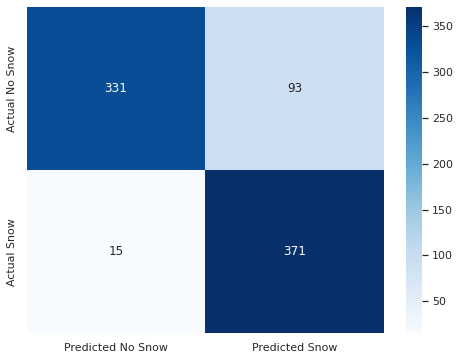

In [92]:
# visualize the confusion matrix

y_test_pred = model.predict(X_test)

y_test_pred = (y_test_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_test_pred)

index_names  = ["Actual No Snow", "Actual Snow"]
column_names = ["Predicted No Snow", "Predicted Snow"]

df_cm = pd.DataFrame(cm, index = index_names, columns = column_names)

plt.figure(figsize = (8, 6))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues");

From confussion matrix we see the samples are mainly distributed on the diagonal, and there are more false-positives than false-negatives. Therefore, alhtough the network is suitable for detecting snow, we should expect some false detections.

In [93]:
# calculate Recall, Precision, and F-score performance metrics
# TN = cm[0][0], TP = cm[1][1], FN = cm[1][0], FP = cm[0][1]

def calculate_metrics(y_test, y_pred, name='value'):

    return pd.DataFrame({'Accuracy': round(accuracy_score(y_test, y_pred), 3),  # (TP + TN) / (TP + TN + FN + FP)
                         'Recall': round(recall_score(y_test, y_pred), 3),  # TP / (TP + FP)
                         'Precision': round(precision_score(y_test, y_pred), 3),  # TP / (TP + FN)
                         'F1-score': round(f1_score(y_test, y_pred), 3)},  # (2 * recall * precision) / (recall + precision)
                       index=[name])
    
calculate_metrics(y_test, y_test_pred)

Accuracy  Recall  Precision  F1-score
value     0.867   0.961        0.8     0.873

As we can see from the high **recall**, our model can forecast the snow with high confidence. However, because of lower **precision** we should expect some false alarms. Finally, **F1-score** tells us **recall** and **precision** are well-balanced. Therefore, we have a good ML model suitable for microcontroller deployment.

In [94]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       424
           1       0.80      0.96      0.87       386

    accuracy                           0.87       810
   macro avg       0.88      0.87      0.87       810
weighted avg       0.88      0.87      0.87       810



26/26 [==============================] - 0s 3ms/step


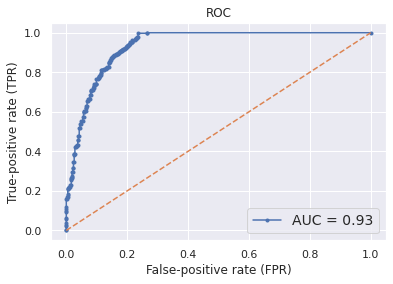

In [95]:
# ROC-AUC metric

y = y_test
scores = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y, scores)

plt.plot(fpr, tpr, '.-', label = "AUC = %.2f" % roc_auc_score(y, scores))
plt.xlabel("False-positive rate (FPR)")
plt.ylabel("True-positive rate (TPR)")
plt.title("ROC")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.legend(loc="lower right", prop={'size': 14})
plt.show()

26/26 [==============================] - 0s 2ms/step


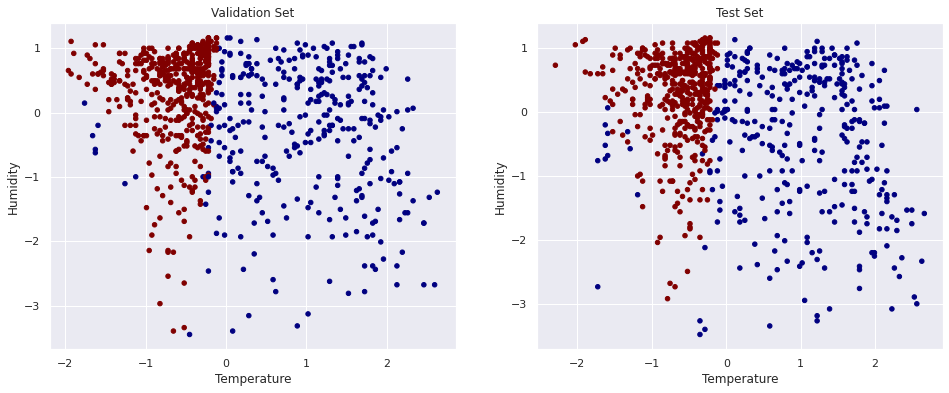

In [96]:
# for completeness, the predictions for validation and test sets

cm = plt.cm.get_cmap('jet')
plt.figure(figsize=(16, 6))
    
for i, dateset, label in zip([1, 2], [X_validate, X_test], ["Validation Set", "Test Set"]):
    
    temp = np.mean(dateset[['Temp0', 'Temp1', 'Temp2']], axis=1).values
    humi = np.mean(dateset[['Humi0', 'Humi1', 'Humi2']], axis=1).values

    preds = (model.predict(dateset) > 0.5).astype("int32")

    plt.subplot(1, 2, i)
    plt.scatter(temp, humi, s=20, c=preds, cmap=cm)

    plt.grid(True)
    plt.title(label)
    plt.xlabel("Temperature")
    plt.ylabel("Humidity")

plt.show()

## Best Model Searching

### Scikit-learn models

Even if we do not have access to `sklearn` models using **TinyML** frawemork, let see how simple NN compares with different `sklearn` models. We observe that NN works a little worse than `KNeighborsClassifier` but it depends on the observed metric. Nethertheless, none of the models has strongly higher performance than NN thus using `Keras` library for weather forecasting on actual dataset is a reasonable choice (actually, the only possible within **TFLu**).

In [97]:
sklearn_models =  [
            DecisionTreeClassifier(),
            KNeighborsClassifier(),
            LogisticRegression(max_iter=NUM_EPOCHS),
            MLPClassifier(hidden_layer_sizes=23, max_iter=NUM_EPOCHS, alpha=0, activation="relu", batch_size=BATCH_SIZE,
                          early_stopping=True, n_iter_no_change=10)  # model without 'Dropout()'
                    ]

df = pd.DataFrame()
for i, model in enumerate(sklearn_models):
    
    model.fit(X_train, y_train)
    df = pd.concat([df,
                    calculate_metrics(y_validate, np.round(model.predict(X_validate)),
                            name=str.replace(model.__class__.__name__, 'Classifier', ''))])
    
df

Accuracy  Recall  Precision  F1-score
DecisionTree           0.836   0.813      0.849     0.831
KNeighbors             0.871   0.933      0.827     0.877
LogisticRegression     0.852   0.918      0.809     0.860
MLP                    0.877   0.965      0.818     0.886

### More complicated NN architecture

In [110]:
tf.keras.utils.set_random_seed(123)

model = Sequential()

model.add(Dense(24, activation="tanh", input_shape=(X_train.shape[1], ),
                kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dense(12, activation="tanh",  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(6, activation="tanh",  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid",  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 24)                168       
                                                                 
 dense_13 (Dense)            (None, 12)                300       
                                                                 
 dropout_6 (Dropout)         (None, 12)                0         
                                                                 
 dense_14 (Dense)            (None, 6)                 78        
                                                                 
 dropout_7 (Dropout)         (None, 6)                 0         
                                                                 
 dense_15 (Dense)            (None, 1)                 7         
                                                                 
Total params: 553
Trainable params: 553
Non-trainable 

The **size of the current model** (in terms of number of weights) is **5 times larger** than the first simple model, so we are probably closer to the **memory limit of microcontroller** (as will be explained later on) - considering mode complicated models make no sense. Of course, it is rather a rough estimate as we need to take into account the memory occupation by TinyML application (written in C) on microcontroller. **But from this we will see how large models are available.**

In [111]:
early_stopping = EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=NUM_EPOCHS,
          callbacks=[early_stopping], batch_size=BATCH_SIZE)

model.evaluate(X_test, y_test, verbose=0)

Epoch 1/50
102/102 [==============================] - 2s 7ms/step - loss: 0.8624 - accuracy: 0.7175 - val_loss: 0.7065 - val_accuracy: 0.8483
Epoch 2/50
102/102 [==============================] - 0s 4ms/step - loss: 0.7171 - accuracy: 0.8114 - val_loss: 0.5989 - val_accuracy: 0.8594
Epoch 3/50
102/102 [==============================] - 0s 5ms/step - loss: 0.6419 - accuracy: 0.8218 - val_loss: 0.5389 - val_accuracy: 0.8631
Epoch 4/50
102/102 [==============================] - 1s 9ms/step - loss: 0.5791 - accuracy: 0.8321 - val_loss: 0.4996 - val_accuracy: 0.8594
Epoch 5/50
102/102 [==============================] - 1s 8ms/step - loss: 0.5555 - accuracy: 0.8326 - val_loss: 0.4730 - val_accuracy: 0.8619
Epoch 6/50
102/102 [==============================] - 1s 11ms/step - loss: 0.5367 - accuracy: 0.8371 - val_loss: 0.4588 - val_accuracy: 0.8631
Epoch 7/50
102/102 [==============================] - 1s 11ms/step - loss: 0.5119 - accuracy: 0.8408 - val_loss: 0.4466 - val_accuracy: 0.8668
Epoc

[0.436290442943573, 0.8691357970237732]

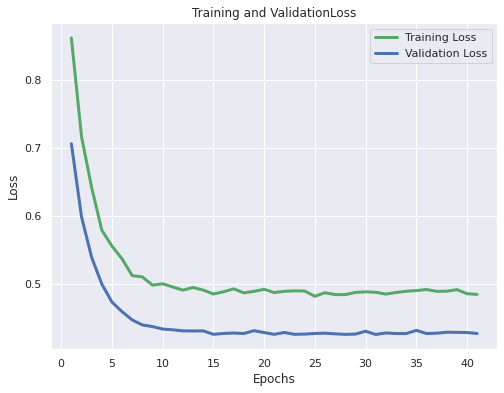

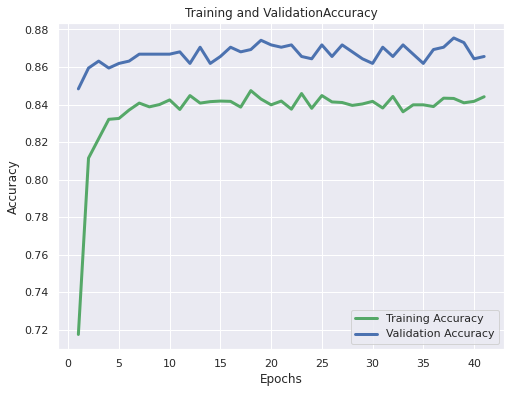

In [112]:
# analyze the accuracy and loss after each training epoch

loss_train = history.history['loss']
loss_val   = history.history['val_loss']
acc_train  = history.history['accuracy']
acc_val    = history.history['val_accuracy']
epochs     = range(1, len(loss_train) + 1)  # range(1, N_EPOCHS + 1) does not include early stopping condition

plot_train_val_history(epochs, loss_train, loss_val, "Loss")
plot_train_val_history(epochs, acc_train, acc_val, "Accuracy")

In [113]:
pd.concat([calculate_metrics(y_train, np.round(model.predict(X_train)), name='Train'),
           calculate_metrics(y_validate, np.round(model.predict(X_validate)), name='Validation'),
           calculate_metrics(y_test, np.round(model.predict(X_test)), name='Test')
          ])

26/26 [==============================] - 0s 3ms/step


Accuracy  Recall  Precision  F1-score
Train          0.856   0.978      0.788     0.872
Validation     0.871   0.980      0.802     0.882
Test           0.869   0.974      0.797     0.876

We can see that building more complicated NN does not improve model performance. For **testing set** the model accuracy is higher but comparable to **training set** thus the probable reason for drop in accuracy for **validation set** is the small set size. However, in case we were unlucky in choosing particular model hyperparameters, we can perform `GridSearch` or `RandomSearch` procedure.

### Hyperparameters Search with `Keras`

To make the `GridSearch` or `RandomSearch` methods typically used with `sklearn` models applicable to `keras` networks, we need to define a model in `create_model` function and then use `KerasClassifier` wrapper as described [here](https://saturncloud.io/blog/how-to-perform-gridsearch-with-keras-neural-networks/) (what follows is a typical searching procedure used with `sklearn`).

In [114]:
def create_model(input_dim, hidden_layers, neurons, activation, dropout_rate, optimizer):
    
    model = Sequential()
    model.add(Dense(units=neurons, activation=activation, input_dim=input_dim))

    for i in range(hidden_layers):
        model.add(Dense(units=neurons, activation=activation))
        model.add(Dropout(dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

**Grid Search**

In [115]:
hidden_layers = [1, 2, 3]
neurons = [6, 12, 24, 48]
activation = ['relu', 'sigmoid']
dropout_rate = [0.1, 0.2, 0.5]
optimizer = ['adam', 'sgd']

param_grid = dict(hidden_layers=hidden_layers,
                  neurons=neurons,
                  activation=activation,
                  dropout_rate=dropout_rate,
                  optimizer=optimizer)

model = KerasClassifier(build_fn=create_model, verbose=0, input_dim=X_train.shape[1])
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

start=time.time()
grid.fit(X_train, y_train)
end = time.time() - start

print(f'Finished, time elapsed: {round(end, 1)} sec')

Finished, time elapsed: 290.8 sec


In [116]:
scores = grid.cv_results_['mean_test_score']
params = grid.cv_results_['params']

zipped = list(zip(scores, params))
scores, params = zip(*sorted(zipped, key=lambda x: x[0]))

print(f'Worst Score: {round(scores[0], 3)} for: {params[0]}')
print(f'Best Score: {round(scores[-1], 3)} for: {params[-1]}')

Worst Score: 0.491 for: {'activation': 'sigmoid', 'dropout_rate': 0.5, 'hidden_layers': 3, 'neurons': 48, 'optimizer': 'sgd'}
Best Score: 0.859 for: {'activation': 'relu', 'dropout_rate': 0.1, 'hidden_layers': 2, 'neurons': 48, 'optimizer': 'adam'}


**Randomized Search**

In [117]:
hidden_layers = [1, 2, 3]
neurons = [5, 10, 15, 20, 25, 30]
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']

param_grid = dict(hidden_layers=hidden_layers,
                  neurons=neurons,
                  activation=activation,
                  dropout_rate=dropout_rate,
                  optimizer=optimizer)

model = KerasClassifier(build_fn=create_model, verbose=0, input_dim=X_train.shape[1])
rs = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_jobs=-1, cv=3, n_iter=50)

start=time.time()
rs.fit(X_train, y_train)
end = time.time() - start

print(f'Finished, time elapsed: {round(end, 1)} sec')

Finished, time elapsed: 120.1 sec


In [118]:
scores = rs.cv_results_['mean_test_score']
params = rs.cv_results_['params']

zipped = list(zip(scores, params))
scores, params = zip(*sorted(zipped, key=lambda x: x[0]))

print(f'Worst Score: {round(scores[0], 3)} for: {params[0]}')
print(f'Best Score: {round(scores[-1], 3)} for: {params[-1]}')

Worst Score: 0.372 for: {'optimizer': 'Adadelta', 'neurons': 30, 'hidden_layers': 3, 'dropout_rate': 0.2, 'activation': 'softsign'}
Best Score: 0.856 for: {'optimizer': 'RMSprop', 'neurons': 30, 'hidden_layers': 3, 'dropout_rate': 0.4, 'activation': 'tanh'}


In [119]:
# train the best found model

best_model = rs.best_estimator_
history = best_model.fit(X_train, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_validate, y_validate))

In [120]:
# Accuracy metrics on test dataset
print(f'Accuracy: {best_model.score(X_test, y_test)}')

Accuracy: 0.8666666746139526


The _mean scores_ on _cross-validation data_ varies from below 0.50 (**overfitting** or **underfitting** on the _training set_ or ) to high values around 0.85-0.90 which means the model works well also on _validation data_. For now, because of the comparable results and rather artificial conditions, I have decided to deploy the first simple model trained due to limited capacity of flash memory on microcontrollers (converting a model within **TinyML** framework is quite a simple process).

In [121]:
# save the entire TensorFlow model as a SavedModel (ProtoBuffer, TF checkpoint and training parameters)
# best_model.save(f'outputs/{TF_MODEL}')

## TensorFlow Lite Conversion

[**TFLite**](https://www.tensorflow.org/lite/guide) is a deep learning framework specifically for inference on edge devices (smartphones and embedded platforms) which provides a set of tools for converting the **TF** model into a lightweight representation and running the model efficiently on the target device, as presented in the following diagram:

<br>
<p align="center" width="100%">
 <img src="./graphics/TLFu_scheme1.png" width="600"/>
</p>

<br>


In [122]:
# import the TensorFlow SavedModel directory into TensorFlow Lite Converter
converter = tf.lite.TFLiteConverter.from_saved_model(f'outputs/{TF_MODEL}')

Memorory constraint is not the only challenge when deploying a model on microcontrollers. Although the trained model commonly employs arithmetic operations in floating-point precision, CPUs on microcontrollers normally do not support them. [**Quantization**](https://www.tensorflow.org/lite/performance/post_training_quantization) is the process of performing neural network computations in lower bit precision. The widely adopted technique for microcontrollers applies quantization post-training and converst 32-bit floating-point weights to 8-bit integer values. This technique brings four times model size reduction and a significant latency improvement but may induce __accuracy drop__.

In [123]:
# TFLite converter uses X_test for calibration

def representative_data_gen():
    '''Select a few hundred of samples randomly from the training dataset to calibrate the quantization'''
    for i_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
        i_value_f32 = tf.dtypes.cast(i_value, tf.float32)
    yield [i_value_f32]

In [124]:
# initialize TensorFlow Lite converter for the 8-bit quantization

converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

The previous step is commonly called _generating a representative dataset_, and is essential to reduce the risk of an accuracy drop in the quantization process. In fact, the converter uses this set of samples to find out the range of the input values and then estimates the quantization parameters.

In [125]:
# convert the model to TensorFlow Lite file format (FlatBuffers) and save it as .tflite

tflite_model_quant = converter.convert()
open(f'outputs/{TFL_MODEL_FILE}', "wb").write(tflite_model_quant)

fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


2088

In [126]:
# convert the TensorFlow Lite model to C-byte array with xxd
 
!apt-get update && apt-get -qq install xxd

!xxd -i outputs/{TFL_MODEL_FILE} > outputs/{TFL_MODEL_HEADER_FILE}  # model conversion and storage in 'model.h' C header file  
!cat outputs/{TFL_MODEL_HEADER_FILE}  # array of hexadecimal numbers interpreted by TFLu framework on microcontroller

Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
unsigned char outputs_forecast_model_tflite[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x14, 0x00, 0x20, 0x00, 0x1c, 0x00, 0x18, 0x00, 0x14, 0x00, 0x10, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x04, 0x00, 0x14, 0x00, 0x00, 0x00,
  0x1c, 0x00, 0x00, 0x00, 0x84, 0x00, 0x00, 0x00, 0xdc, 0x00, 0x00, 0x00,
  0x5c, 0x02, 0x00, 0x00, 0x6c, 0x02, 0x00, 0x00, 0xb8, 0x07, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x5a, 0xfd, 0xff, 0xff, 0x0c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00,
  0x38, 0x00, 0x00, 0x00, 0x0f, 0x00, 0x00, 0x00, 0x73, 0x65, 0x72, 0x76,


The `xxd` command outputs a C header file containing __TFLite__ model as C-byte array since microcontrollers may not have (or very limited) [__MbedOS__](https://os.mbed.com/mbed-os/) and support for loading the data from original `*.tflite` file. Therefore, it allows us to integrate the model directly into the application in a memory-efficient way.

### Evaluating the accuracy of the TFLite quantized model

Post-training quantization may change the model accuracy because of the arithmetic operations at a lower precision. Therefore, it is crucial to check whether the accuracy of the generated `*.tflite` model is within an acceptable range before deploying it into the microcontroller.

In [127]:
def classify(i_value, o_value):
    input_data = i_value.reshape(1, -1)
    i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
    # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
    i_value_f32 = i_value_f32 / i_scale + i_zero_point
    i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)

    tfl_inter.set_tensor(i_details["index"], i_value_s8)
    tfl_inter.invoke()
    o_pred = tfl_inter.get_tensor(o_details["index"])[0]

    return (o_pred - o_zero_point) * o_scale

In [128]:
# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model_quant)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]
o_scale      = o_quant['scales'][0]
o_zero_point = o_quant['zero_points'][0]

num_correct_samples = 0
num_total_samples   = len(list(y_test))

for i_value, o_value in zip(X_test.values, y_test):
    o_pred_f32 = classify(i_value, o_value)
    if np.argmax(o_pred_f32) == o_value:
        num_correct_samples += 1

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [129]:
print("Accuracy:", num_correct_samples / num_total_samples)

Accuracy: 0.5234567901234568


**Unfortunately, the model after quantization is no better than simple guessing!** Thus it requires some floating-point conversion improvements to have the accuracy comparable to the full model tested on PC (the reason can be the dataset quality so data from other locations need to be tested as well).

## Deployment on Arduino Board

**Arduino Nano 33 BLE Sens** has built-in __TPH__ (temperature, pressure and humidity) sensors so we do not need external components for building a simple weather station. The Arduino board integrates ultra-compact and extremaly low-power [HTS221 sensor](https://www.st.com/en/mems-and-sensors/hts221.html) for relative humidity and temperature measurements.

<br>
<p align="center" width="100%">
 <img src="./graphics/sensor_params.png" width="600"/>
</p>

<br>

> __IMPORTANT__: Due to [self-heating](https://forum.arduino.cc/t/how-to-make-a-weather-station-and-fix-temperature-sensor-readings-on-the-sense/624985), when the **Arduino Nano 33 BLE Sens** board is powered by USB, the HTS221 sensor becomes unreliable and shows an offset in each reading that changes with the external temperature. Thus, powering the board with batteries is recommended.

Please find an additional Jupyter Notebook with [ArduinoSketches](./notebook_ArduinoSketches.ipynb) written in C language for __TFLu__ model deployment on **Arduino Nano 33 BLE Sens** board. __TFLu__ framework does not need setting up as it is included as a separate library in the Arduino IDE environment. For those interested, very good, official tutorial showing how to configure the Arduino IDE, install __TFLu__ library and run first programs on **Arduino Nano 33 BLE Sens** can be found [here](https://docs.arduino.cc/tutorials/nano-33-ble-sense/get-started-with-machine-learning). Inference with __TFLu__ typically consists of the following steps, implemented in the Arduino application via external libraries:
1. __Loading and parsing the TFLite model__: TFLu parses the weights and network architecture stored in the C-byte array generated before
2. __Transforming the input data__: the input data acquired from the sensors is converted to the quantized format expected by the TFLu model
3. __Executing the model__: TFLu executes the model using optimized deep neural network functions (like convolutions, matrix multiplications, etc.)

> __NOTE__: At the end of Arduino sketches code, there is a delay of <u>two seconds</u> but is should be <u>one hour</u> in the actual application! The pause of two seconds is used to avoid waiting too long in our experiments (we have decided to predict weather in an hourly manner). Also, in the `DEBUG_SNOW` mode there are implemented conditions where model predict snowing weather (to check if the logic of Arduino application works). Please remember that **mean** and **std** of temperature and humidity extracted from TF model <u>must be copied</u> into Arduino code as well.

After compiling and uploading the `classification.ino` sketch on the Arduino board (_sketch - including **simple model** - uses 25% of program storage space. Global variables use 19% of dynamic memory_), the serial port monitor in the _Arduino IDE_ will report ***Yes, it snows*** or ***No, it does not snow***, depending on whether snow is forecast at the moment. To check if the application can forecast snow, you can simply force the temperature to -10 Celsisus degree and humidity to 100%. The model should then return ***Yes, it snows*** message on the serial port monitor.

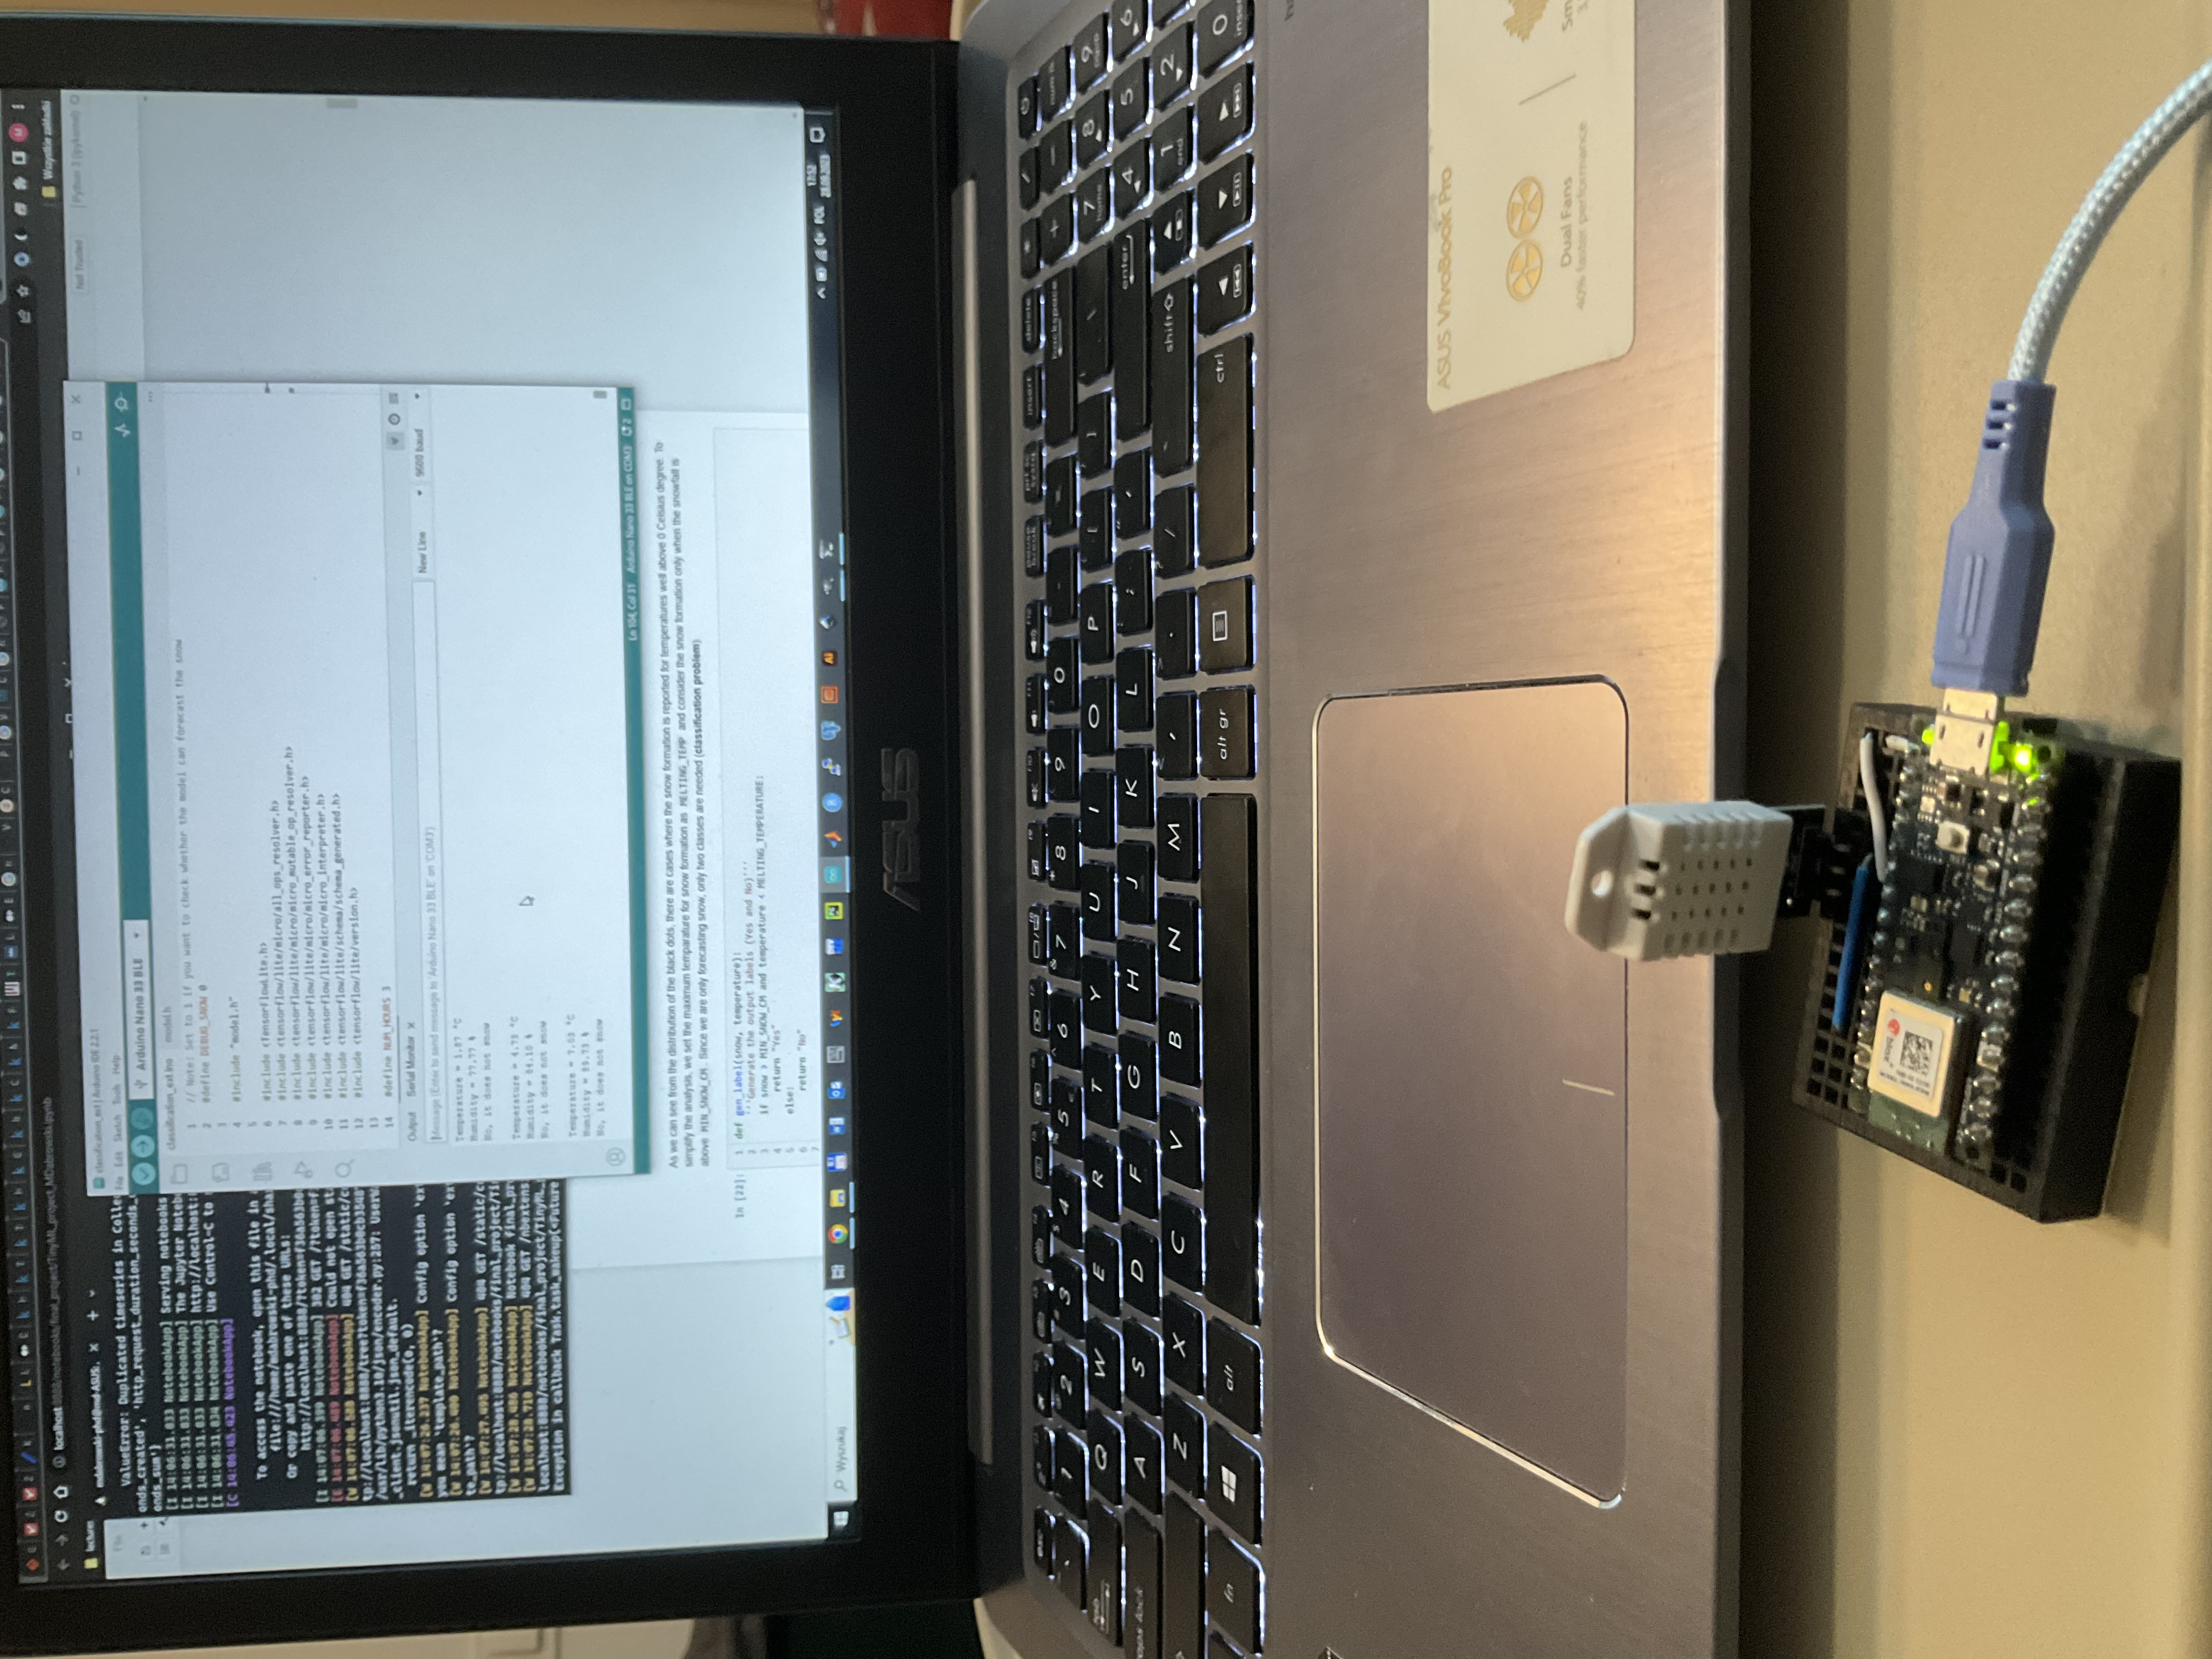
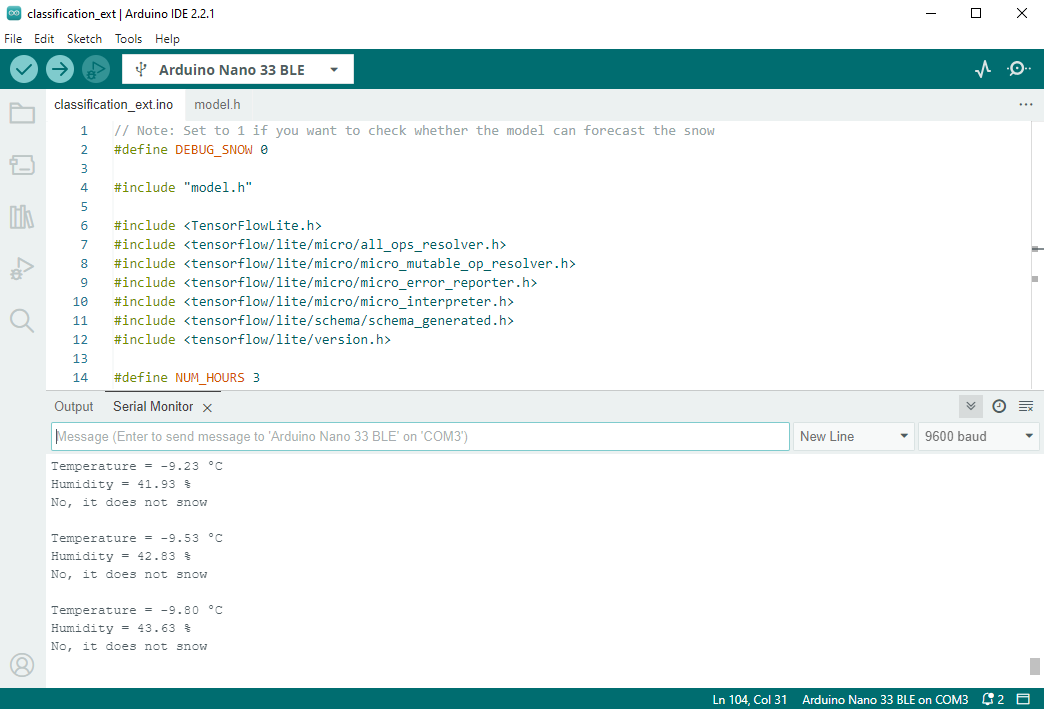

## Conclusions and Perspectives

### Short summary

To conclude, I have trained and deployed the TinyML model on both **Arduino Nano 33 BLE Sens** and **RaspberryPi Pico** boards, achieving c.a. 90% accuracy in snow weather prediction in Warsaw based on the temperature and humidity from the past three hours. The data were downloaded using freely available [web API](https://www.worldweatheronline.com/weather-api/api/docs/historical-weather-api.aspx) with historical weather forecast for different locations worldwide. In my analysis, I have been limited by available [TensorFlowLite models](https://www.tensorflow.org/lite/models) (thus only neural networks models are possible to deploy) as well as by memory constrains (1MB flash and 256kB SRAM on **Arduino Nano**) of microcontrollers platforms which limits the size of the model (the number of _weights_ and [_mathematical operations_](https://github.com/tensorflow/tflite-micro/blob/main/tensorflow/lite/micro/micro_mutable_op_resolver.h)). In principle, bigger model can be implemented on **RaspberryPi Pico** (4 x more memory). Also, including more data features to analysis require more sophisticated sensors and data processing algorithms which right now cannot be implemented in the **TinyML** application. For example, adding `PCA` step to identify possible variables or clusters will be beneficial but imposible due to model deployment on microcontroller. Moreover, model should work in **real-time** so the _latency_ must be small (which is hard for complicated models). The model was tested on microcontrollers based on the sensors measurements pointing important point about model quantization (which is crucial for model _latency_ and _memory constrains_ but can completety distroy the accuracy of predictions).

### Future improvements

**However, there is still room for improvevements.** Instead of building DL models from scratch, one can try **transfer learning** using prepared models by **TensorFlow Lite** (limited to NN networks only). Microcontroller can send the measured data directly to PC for model training (no calibration needed) and after a long time we can create the dataset which then can be used for model training. Up to now, **TFLU** framework does not allow for [_on-device training_](https://blog.tensorflow.org/2021/11/on-device-training-in-tensorflow-lite.html) and only testing on microcontrollers but more general architectures ([_federated_](https://en.wikipedia.org/wiki/Federated_learning) or [_on-line training_](https://en.wikipedia.org/wiki/Online_machine_learning)) will be available. To increase the model complexity thus maybe predictions accuracy as well, we can use another sensors as **CCD camera** for measuring cloudness or **preasure sensor** for atmospheric preasure measurements (we can even think of using **microphone** for measuring wind speed based on the sound it produces). During the analysis, **we treat data samples as independent** but in fact they are part of a time series thus it is worth trying `CNN` or `RNN` models (however, this requires more microcontrollers memory to collect data for longer times or implementation of the communication protocol between PC and microcontroller). In such a situation, _rolling statistics_ (moving average) or _lagged values_ (stored in the memory) might help as additional features. It is worth remembering the microcontroller memory must be splitted into model and application rutine. In a short term, it is worth checking if more sophisticated methods in the EDA process when removing duplicated or imputing missing indexes provide better results when testing the model.